In [300]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [301]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [302]:
import VAE_tybalt
from VAE_tybalt import VAE

In [303]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [304]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

## Load data

In [87]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [88]:
rnaseq_df.head(5)

RPS4Y1      XIST      KRT5  AGR2   CEACAM5     KRT6A     KRT14   CEACAM6  \
0  0.678296  0.289910  0.034230   0.0  0.000000  0.084731  0.031863  0.037709   
1  0.200633  0.654917  0.181993   0.0  0.000000  0.100606  0.050011  0.092586   
2  0.785980  0.140842  0.081082   0.0  0.000000  0.000000  0.000000  0.000000   
3  0.720258  0.122554  0.180042   0.0  0.000000  0.000000  0.000000  0.000000   
4  0.767127  0.210393  0.034017   0.0  0.061161  0.000000  0.053021  0.000000   

      DDX3Y     KDM5D  ...   FAM129A   C8orf48    CDK5R1    FAM81A  C13orf18  \
0  0.746797  0.687833  ...  0.440610  0.428782  0.732819  0.634340  0.580662   
1  0.103725  0.140642  ...  0.620658  0.363207  0.592269  0.602755  0.610192   
2  0.730648  0.657189  ...  0.437658  0.471489  0.868774  0.471141  0.487212   
3  0.720306  0.719855  ...  0.553306  0.373344  0.818608  0.691962  0.635023   
4  0.739546  0.665684  ...  0.601268  0.379943  0.506839  0.684320  0.607821   

      GDPD3     SMAGP   C2orf85   POU5F1B     CHST2  
0  0.294313  0.458134  0.478219  0.168263  0.638497  
1  0.374569  0.722420  0.271356  0.160465  0.602560  
2  0.385521  0.466642  0.784059  0.160797  0.557074  
3  0.430647  0.453690  0.364494  0.161363  0.607895  
4  0.320113  0.476190  0.122722  0.389544  0.698548  

[5 rows x 5000 columns]

### Find genes which have high correlations

In [321]:
# Compute the correlation matrix
corr_matrix = rnaseq_df.corr()

# Find highly correlated columns
threshold = 0.9  # Set the correlation threshold (adjust as needed)
highly_correlated = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated.add(colname_i)
            highly_correlated.add(colname_j)

In [322]:
len(highly_correlated)

276

### Generate a deep copy of the original dataframe

In [323]:
rnaseq_df_noisy = rnaseq_df.copy()

### Add noise to correlated genes (corr > 0.9)

In [324]:
# Creat a dictionary holding data where highest correlated genes are perturbed.
import random

In [325]:
def add_noise_to_n_genes(df, n, corr_genes):
    genes = random.sample(corr_genes, n)
    df_noisy = df.copy()
    noise_std = 0.3
    # Add noise to the selected columns
    for column_name in genes:
        noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
        df_noisy[column_name] = df_noisy[column_name] + noise

    return df_noisy

In [326]:
num_genes = list(range(1, len(highly_correlated), 10))
noisy_inputs = {
    i: add_noise_to_n_genes(rnaseq_df, i, list(highly_correlated)) for i in num_genes
}

In [327]:
# Set the noise standard deviation
noise_std = 0.5

# Add noise to the selected columns
for column_name in highly_correlated:
    noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
    rnaseq_df_noisy[column_name] = rnaseq_df_noisy[column_name] + noise

### Check model performace

In [328]:
BCEs = []
for i in noisy_inputs.keys():
    df = noisy_inputs[i]
    recon_batch, latent, _, _, _ = model(torch.tensor(df.values, dtype=torch.float32))
    BCE = model.loss_function_dist(
        recon_batch, torch.tensor(rnaseq_df.values, dtype=torch.float32), latent, 5000
    ).item()
    BCEs.append(BCE)

Text(0, 0.5, 'Binary Cross Entropy')

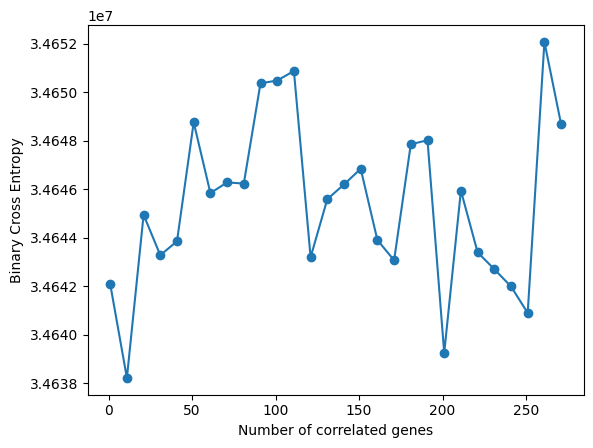

In [329]:
plt.plot(num_genes, BCEs, "-o")
plt.xlabel("Number of correlated genes")
plt.ylabel("Binary Cross Entropy")

In [330]:
def bce_loss_function_dist(recon_x, x, latent, input_dim):
    prior = MultivariateNormal(
        loc=torch.zeros(latent.mean.shape[1]),
        scale_tril=torch.eye(latent.mean.shape[1]),
    )

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction="sum")
    return BCE

In [331]:
BCEs = []
for i in noisy_inputs.keys():
    df = noisy_inputs[i]
    recon_batch, latent, _, _, _ = model(torch.tensor(df.values, dtype=torch.float32))
    BCE = bce_loss_function_dist(
        recon_batch, torch.tensor(rnaseq_df.values, dtype=torch.float32), latent, 5000
    ).item()
    BCEs.append(BCE)

Text(0, 0.5, 'Binary Cross Entropy')

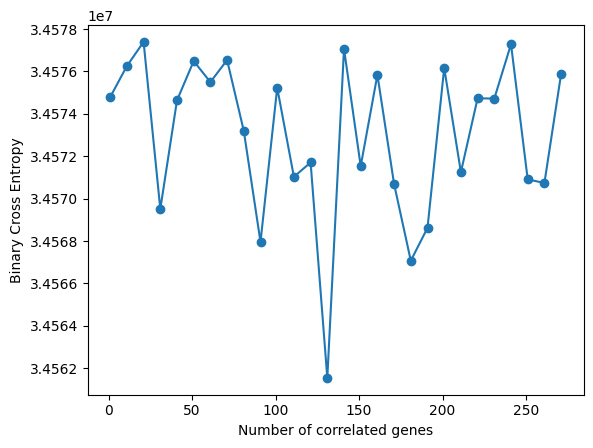

In [332]:
plt.plot(num_genes, BCEs, "-o")
plt.xlabel("Number of correlated genes")
plt.ylabel("Binary Cross Entropy")

In [333]:
filtered_df = corr_matrix.loc[list(highly_correlated), list(highly_correlated)]

### Compute and compare the correlation between genes after reconstruction 

In [334]:
# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe

In [335]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

### Look at the correlation matrix of reconstructed genes for input genes which are highly correlated

In [336]:
VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()

ZIC1  CYorf15A      ORM1   SLC17A3      CDC6    LGALS7  \
ZIC1      1.000000 -0.100885 -0.118518 -0.183861 -0.043897 -0.148394   
CYorf15A -0.100885  1.000000  0.183602  0.146138 -0.093198 -0.001111   
ORM1     -0.118518  0.183602  1.000000  0.179970  0.035730 -0.040438   
SLC17A3  -0.183861  0.146138  0.179970  1.000000 -0.476861 -0.289324   
CDC6     -0.043897 -0.093198  0.035730 -0.476861  1.000000  0.581158   
...            ...       ...       ...       ...       ...       ...   
ORC1L     0.012082  0.009804 -0.079065 -0.318872  0.926688  0.612842   
IPW       0.186726 -0.031297 -0.094662  0.214330 -0.829071 -0.631572   
OR2A7    -0.629910 -0.077792  0.335965  0.099992  0.223108  0.546305   
TMEM176A -0.083417  0.049956  0.275128  0.803346 -0.247088 -0.268549   
CDCA5     0.171672 -0.083032 -0.088670 -0.543810  0.954516  0.551896   

             MCM10    CTAGE4    MAGEA3    COL5A2  ...      AHSG      APCS  \
ZIC1      0.050872 -0.665799  0.192146  0.030155  ...  0.286984  0.086882   
CYorf15A -0.233189 -0.166110  0.015464 -0.333587  ...  0.165022  0.184540   
ORM1     -0.093650  0.289846  0.088347  0.033157  ...  0.767963  0.853836   
SLC17A3  -0.527957  0.112161 -0.266052 -0.211380  ...  0.369073  0.454651   
CDC6      0.948581  0.254098  0.793458  0.521676  ... -0.100956 -0.105851   
...            ...       ...       ...       ...  ...       ...       ...   
ORC1L     0.915024  0.147898  0.780914  0.356647  ... -0.077710 -0.124157   
IPW      -0.761218 -0.341513 -0.699205 -0.474226  ... -0.064445 -0.054339   
OR2A7     0.082220  0.959324  0.158863  0.427419  ... -0.029601  0.079902   
TMEM176A -0.288174  0.192129 -0.175031  0.141642  ...  0.461265  0.572860   
CDCA5     0.963159  0.058813  0.771378  0.422500  ... -0.107298 -0.176618   

            FCGR2B      NPR3    CKMT1B     ORC1L       IPW     OR2A7  \
ZIC1     -0.206642 -0.451633 -0.151365  0.012082  0.186726 -0.629910   
CYorf15A -0.166479  0.118626 -0.026585  0.009804 -0.031297 -0.077792   
ORM1      0.197258  0.085558 -0.227559 -0.079065 -0.094662  0.335965   
SLC17A3   0.159871  0.617426 -0.426378 -0.318872  0.214330  0.099992   
CDC6      0.274694 -0.441211  0.301987  0.926688 -0.829071  0.223108   
...            ...       ...       ...       ...       ...       ...   
ORC1L     0.245861 -0.296043  0.201525  1.000000 -0.804284  0.103739   
IPW      -0.160703  0.311075 -0.440112 -0.804284  1.000000 -0.297939   
OR2A7     0.371691  0.394198  0.464012  0.103739 -0.297939  1.000000   
TMEM176A  0.287009  0.316653 -0.243172 -0.170399 -0.044237  0.135865   
CDCA5     0.139536 -0.521152  0.303750  0.937034 -0.769592  0.014999   

          TMEM176A     CDCA5  
ZIC1     -0.083417  0.171672  
CYorf15A  0.049956 -0.083032  
ORM1      0.275128 -0.088670  
SLC17A3   0.803346 -0.543810  
CDC6     -0.247088  0.954516  
...            ...       ...  
ORC1L    -0.170399  0.937034  
IPW      -0.044237 -0.769592  
OR2A7     0.135865  0.014999  
TMEM176A  1.000000 -0.318146  
CDCA5    -0.318146  1.000000  

[276 rows x 276 columns]

In [337]:
diff_corr_1 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()
)
diff_corr_101 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[101], model)[list(highly_correlated)].corr()
)
diff_corr_201 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[201], model)[list(highly_correlated)].corr()
)
diff_corr_271 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[271], model)[list(highly_correlated)].corr()
)

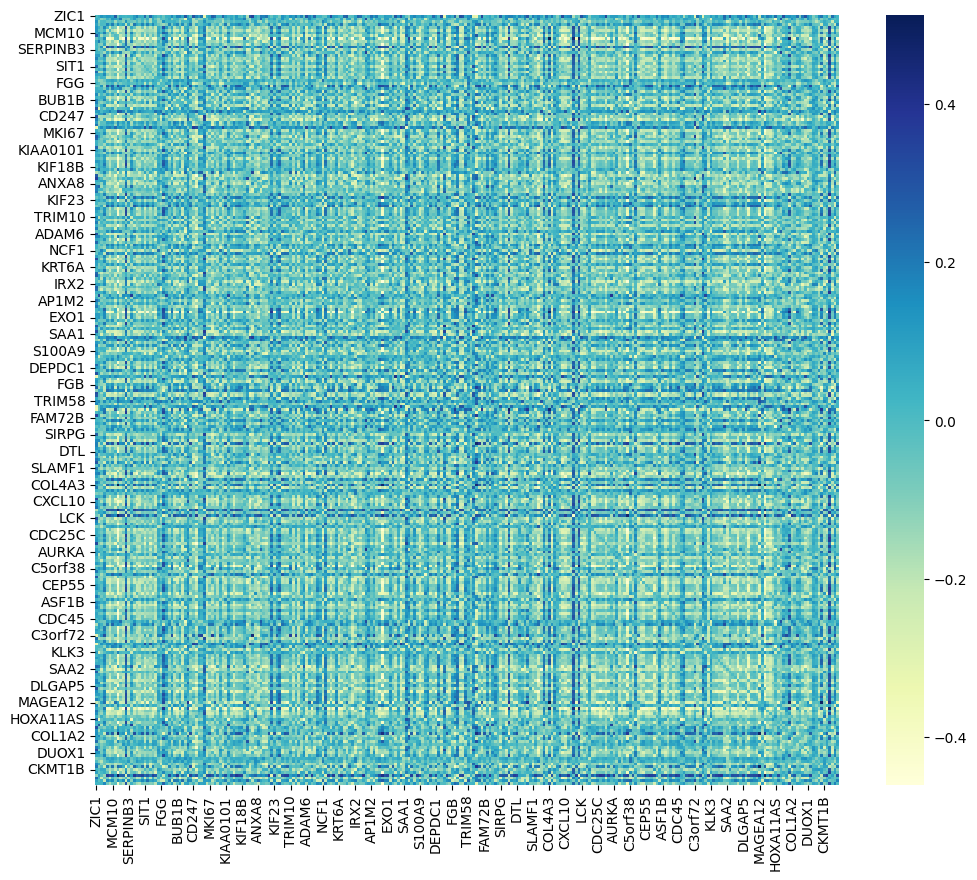

In [338]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_1, cmap="YlGnBu")

# Display the plot
plt.show()

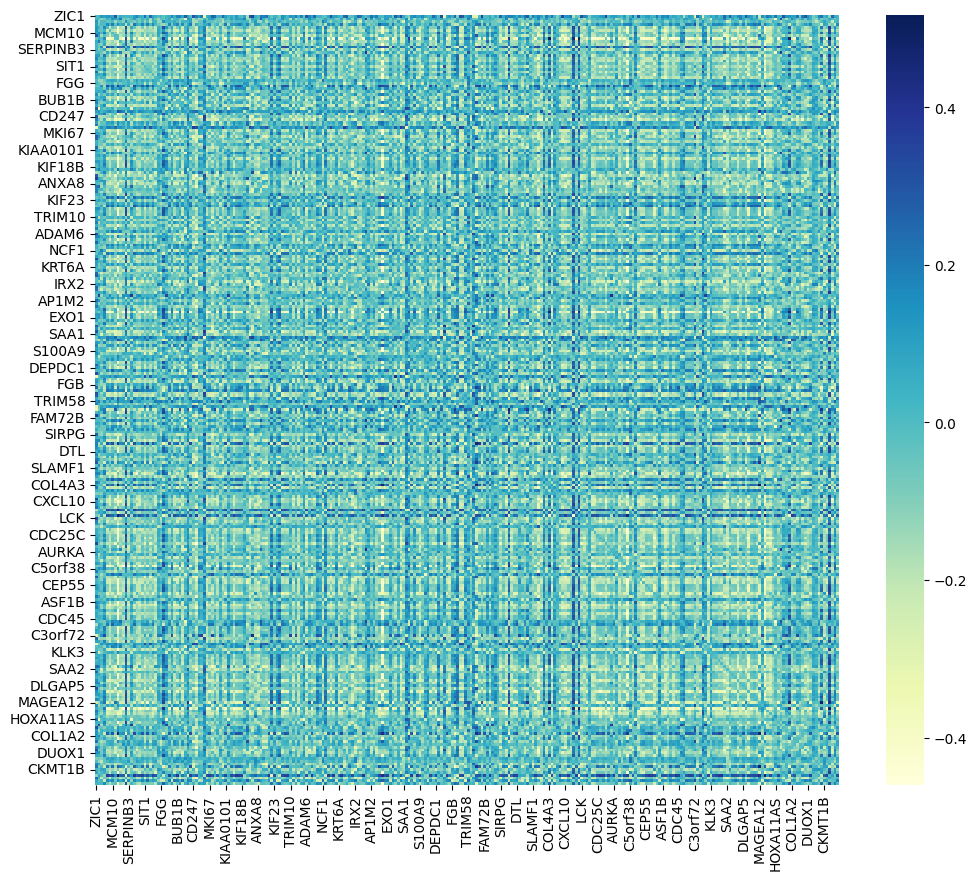

In [339]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_101, cmap="YlGnBu")

# Display the plot
plt.show()

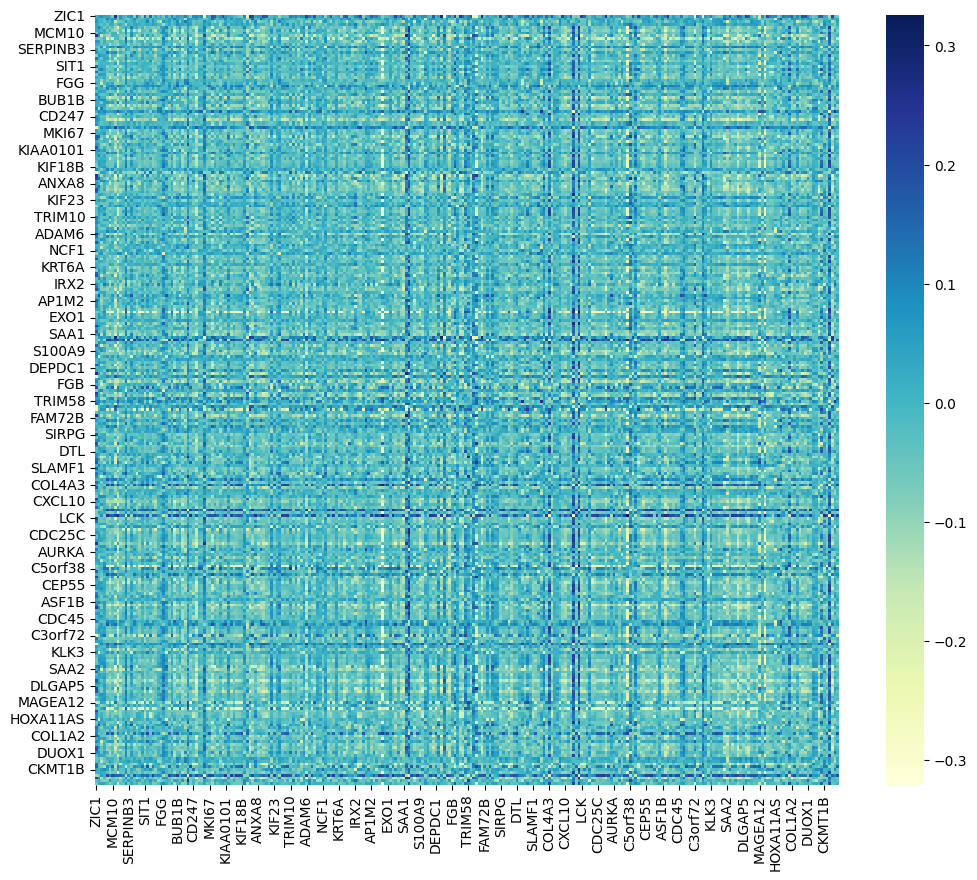

In [105]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_201, cmap="YlGnBu")

# Display the plot
plt.show()

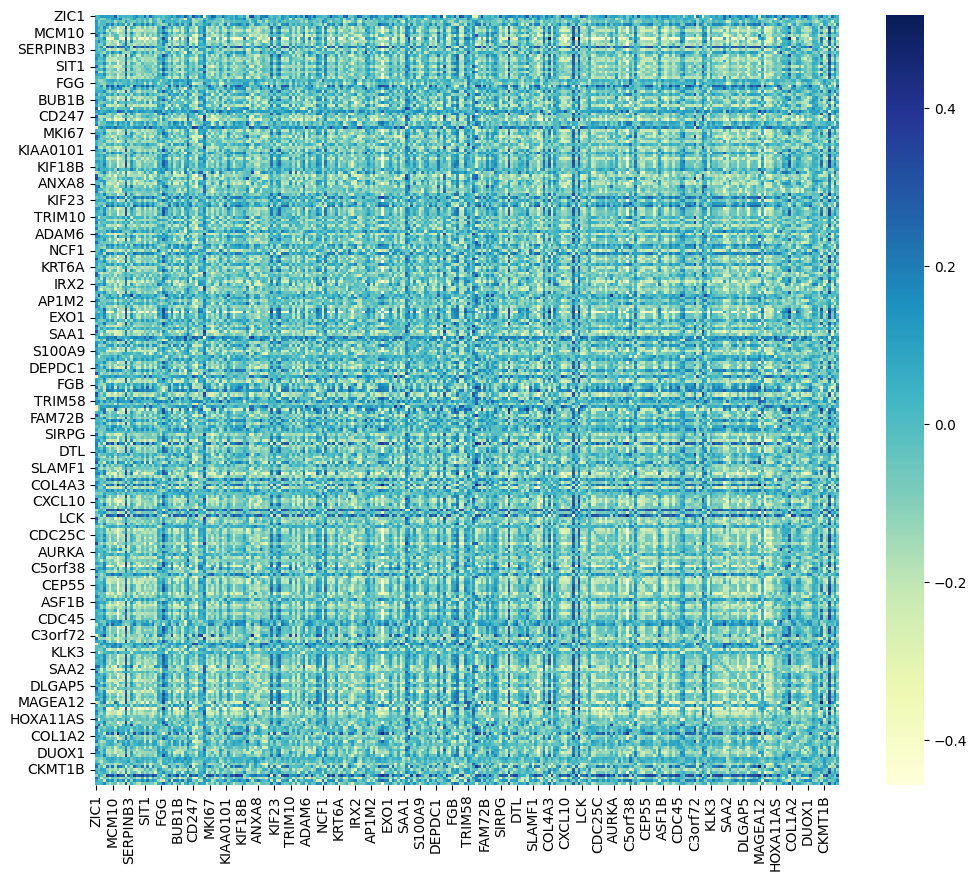

In [340]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_271, cmap="YlGnBu")

# Display the plot
plt.show()

### Perform downstream classification tasks when noise is added to highly correlated genes

In [341]:
# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma

In [342]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)

In [343]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame named 'latent_mu' with the data

# Extract the features from the DataFrame
features = latent_mu.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(features)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([latent_mu, umap_df], axis=1)

In [344]:
embedded_dataframe = result_df.copy()

In [345]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [346]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [347]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [348]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [349]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

In [350]:
def drop_rows_less_than_n_identical(df, column, n):
    # Count the number of identical values in the specified column
    counts = df[column].value_counts()

    # Get the values that have less than n occurrences
    values_to_drop = counts[counts < n].index.tolist()

    # Drop rows that have values less than n occurrences
    df = df[~df[column].isin(values_to_drop)]

    return df


# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

column_name = "acronym"
n = 2

merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

In [351]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.5416934847095539
F1-score: 0.5027519265773165
Accuracy: 0.6768447837150128
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.10      0.09        21
           1       0.75      0.83      0.79       160
           2       0.67      0.32      0.43        19
           3       0.69      0.39      0.50        23
           4       0.00      0.00      0.00         1
           5       0.80      1.00      0.89        16
           6       0.00      0.00      0.00         4
           7       1.00      0.88      0.93         8
           8       0.88      1.00      0.94        29
           9       0.62      0.68      0.65        22
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00         4
          12       1.00      0.82      0.90        22
          13       0.37      0.67      0.47        33
          14       0.90      1.00      0.95         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

### Check how highly correlated perturbed gene influence cancer type classification

In [362]:
# Convert classification report to DataFrame
report_data = []
lines = classification_metrics.strip().split("\n")
for line in lines[2:-3]:
    row = line.split()
    report_data.append(row)

classification_metrics_df = pd.DataFrame(
    report_data, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [363]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

In [364]:
latent_mu_51, latent_sigma_51 = VAE_latent_out(noisy_inputs[51])

In [365]:
# Extract the features from the DataFrame
features_51 = latent_mu_51.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_51 = umap.UMAP().fit_transform(features_51)

# Create a new DataFrame with UMAP coordinates
umap_df_51 = pd.DataFrame(umap_result_51, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_51 = pd.concat([latent_mu_51, umap_df_51], axis=1)

In [366]:
embedded_dataframe_51 = result_df_51.copy()

In [367]:
embedded_dataframe_51["id"] = df["Unnamed: 0"]

In [368]:
merged_latent_clinical_df_51 = pd.merge(
    clincal_df, embedded_dataframe_51, on="id", how="inner"
)

In [369]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_51 = merged_latent_clinical_df_51.copy()
merged_l_df_51 = merged_l_df_51.dropna()

column_name = "acronym"
n = 2

merged_l_df_51 = drop_rows_less_than_n_identical(merged_l_df_51, column_name, n)

In [370]:
merged_l_df_51["acronym"] = merged_l_df_51["acronym"].astype("category").cat.codes

X_51 = merged_l_df_51[["UMAP1", "UMAP2"]]
y_51 = merged_l_df_51["acronym"]

# Split the data into train and test sets
X_train_51, X_test_51, y_train_51, y_test_51 = train_test_split(
    X_51, y_51, test_size=0.2, random_state=42, stratify=y_51
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_51, y_train_51)

# Make predictions on the test set
y_pred_51 = classifier.predict(X_test_51)

# Compute roc_auc_score
auc_roc_51 = roc_auc_score(
    pd.get_dummies(y_test_51), pd.get_dummies(y_pred_51), average="macro"
)

# Compute F1-score
f1_51 = f1_score(y_test_51, y_pred_51, average="macro")

# Compute accuracy
accuracy_51 = accuracy_score(y_test_51, y_pred_51)

# Compute classification report
classification_metrics_51 = classification_report(y_test_51, y_pred_51)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_51)
print("F1-score:", f1_51)
print("Accuracy:", accuracy_51)
print("Classification Report:\n", classification_metrics_51)

AUC-ROC: 0.7556182271760914
F1-score: 0.6930044610966364
Accuracy: 0.7862595419847328
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.29      0.32        21
           1       0.85      0.93      0.89       160
           2       0.62      0.79      0.70        19
           3       0.65      0.57      0.60        23
           4       1.00      1.00      1.00         1
           5       0.94      1.00      0.97        16
           6       0.75      0.75      0.75         4
           7       1.00      0.38      0.55         8
           8       0.97      0.97      0.97        29
           9       0.68      0.68      0.68        22
          10       0.83      0.23      0.36        22
          11       0.00      0.00      0.00         4
          12       1.00      0.95      0.98        22
          13       0.56      0.76      0.64        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [371]:
# Convert classification report to DataFrame
report_data_51 = []
lines_51 = classification_metrics_51.strip().split("\n")
for line in lines_51[2:-3]:
    row = line.split()
    report_data_51.append(row)

classification_metrics_df_51 = pd.DataFrame(
    report_data_51, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [372]:
latent_mu_101, latent_sigma_101 = VAE_latent_out(noisy_inputs[101])

In [373]:
# Extract the features from the DataFrame
features_101 = latent_mu_101.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_101 = umap.UMAP().fit_transform(features_101)

# Create a new DataFrame with UMAP coordinates
umap_df_101 = pd.DataFrame(umap_result_101, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_101 = pd.concat([latent_mu_101, umap_df_101], axis=1)

In [374]:
embedded_dataframe_101 = result_df_101.copy()

In [375]:
embedded_dataframe_101["id"] = df["Unnamed: 0"]

In [376]:
merged_latent_clinical_df_101 = pd.merge(
    clincal_df, embedded_dataframe_101, on="id", how="inner"
)

In [377]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_101 = merged_latent_clinical_df_101.copy()
merged_l_df_101 = merged_l_df_101.dropna()

column_name = "acronym"
n = 2

merged_l_df_101 = drop_rows_less_than_n_identical(merged_l_df_101, column_name, n)

In [378]:
merged_l_df_101["acronym"] = merged_l_df_101["acronym"].astype("category").cat.codes

X_101 = merged_l_df_101[["UMAP1", "UMAP2"]]
y_101 = merged_l_df_101["acronym"]

# Split the data into train and test sets
X_train_101, X_test_101, y_train_101, y_test_101 = train_test_split(
    X_101, y_101, test_size=0.2, random_state=42, stratify=y_101
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_101, y_train_101)

# Make predictions on the test set
y_pred_101 = classifier.predict(X_test_101)

# Compute roc_auc_score
auc_roc_101 = roc_auc_score(
    pd.get_dummies(y_test_101), pd.get_dummies(y_pred_101), average="macro"
)

# Compute F1-score
f1_101 = f1_score(y_test_101, y_pred_101, average="macro")

# Compute accuracy
accuracy_101 = accuracy_score(y_test_101, y_pred_101)

# Compute classification report
classification_metrics_101 = classification_report(y_test_101, y_pred_101)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_101)
print("F1-score:", f1_101)
print("Accuracy:", accuracy_101)
print("Classification Report:\n", classification_metrics_101)

AUC-ROC: 0.5545120537541602
F1-score: 0.5831213382338911
Accuracy: 0.6437659033078881
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.19      0.32        21
           1       0.67      0.84      0.75       160
           2       0.57      0.68      0.62        19
           3       0.00      0.00      0.00        23
           4       1.00      1.00      1.00         1
           5       0.88      0.94      0.91        16
           6       1.00      0.75      0.86         4
           7       0.88      0.88      0.88         8
           8       0.35      0.69      0.47        29
           9       0.00      0.00      0.00        22
          10       0.59      0.59      0.59        22
          11       0.00      0.00      0.00         4
          12       1.00      0.68      0.81        22
          13       0.56      0.55      0.55        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [379]:
# Convert classification report to DataFrame
report_data_101 = []
lines_101 = classification_metrics_101.strip().split("\n")
for line in lines_101[2:-3]:
    row = line.split()
    report_data_101.append(row)

classification_metrics_df_101 = pd.DataFrame(
    report_data_101, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [380]:
latent_mu_151, latent_sigma_151 = VAE_latent_out(noisy_inputs[151])

In [381]:
# Extract the features from the DataFrame
features_151 = latent_mu_151.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_151 = umap.UMAP().fit_transform(features_151)

# Create a new DataFrame with UMAP coordinates
umap_df_151 = pd.DataFrame(umap_result_151, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_151 = pd.concat([latent_mu_151, umap_df_151], axis=1)

In [382]:
embedded_dataframe_151 = result_df_151.copy()

In [383]:
embedded_dataframe_151["id"] = df["Unnamed: 0"]

In [384]:
merged_latent_clinical_df_151 = pd.merge(
    clincal_df, embedded_dataframe_151, on="id", how="inner"
)

In [385]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_151 = merged_latent_clinical_df_151.copy()
merged_l_df_151 = merged_l_df_151.dropna()

column_name = "acronym"
n = 2

merged_l_df_151 = drop_rows_less_than_n_identical(merged_l_df_151, column_name, n)

In [386]:
merged_l_df_151["acronym"] = merged_l_df_151["acronym"].astype("category").cat.codes

X_151 = merged_l_df_151[["UMAP1", "UMAP2"]]
y_151 = merged_l_df_151["acronym"]

# Split the data into train and test sets
X_train_151, X_test_151, y_train_151, y_test_151 = train_test_split(
    X_151, y_151, test_size=0.2, random_state=42, stratify=y_151
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_151, y_train_151)

# Make predictions on the test set
y_pred_151 = classifier.predict(X_test_151)

# Compute roc_auc_score
auc_roc_151 = roc_auc_score(
    pd.get_dummies(y_test_151), pd.get_dummies(y_pred_151), average="macro"
)

# Compute F1-score
f1_151 = f1_score(y_test_151, y_pred_151, average="macro")

# Compute accuracy
accuracy_151 = accuracy_score(y_test_151, y_pred_151)

# Compute classification report
classification_metrics_151 = classification_report(y_test_151, y_pred_151)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_151)
print("F1-score:", f1_151)
print("Accuracy:", accuracy_151)
print("Classification Report:\n", classification_metrics_151)

AUC-ROC: 0.795028762045171
F1-score: 0.7381328962892842
Accuracy: 0.816793893129771
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.71      0.68        21
           1       0.92      0.96      0.94       160
           2       0.64      0.84      0.73        19
           3       0.68      0.83      0.75        23
           4       1.00      1.00      1.00         1
           5       0.94      1.00      0.97        16
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         8
           8       0.93      0.97      0.95        29
           9       0.55      0.27      0.36        22
          10       0.55      0.27      0.36        22
          11       0.00      0.00      0.00         4
          12       0.95      0.82      0.88        22
          13       0.54      0.67      0.59        33
          14       1.00      1.00      1.00         9

    accuracy              

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [387]:
# Convert classification report to DataFrame
report_data_151 = []
lines_151 = classification_metrics_151.strip().split("\n")
for line in lines_151[2:-3]:
    row = line.split()
    report_data_151.append(row)

classification_metrics_df_151 = pd.DataFrame(
    report_data_151, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [388]:
latent_mu_201, latent_sigma_201 = VAE_latent_out(noisy_inputs[201])

In [389]:
# Extract the features from the DataFrame
features_201 = latent_mu_201.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_201 = umap.UMAP().fit_transform(features_201)

# Create a new DataFrame with UMAP coordinates
umap_df_201 = pd.DataFrame(umap_result_201, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_201 = pd.concat([latent_mu_201, umap_df_201], axis=1)

In [390]:
embedded_dataframe_201 = result_df_201.copy()

In [391]:
embedded_dataframe_201["id"] = df["Unnamed: 0"]

In [392]:
merged_latent_clinical_df_201 = pd.merge(
    clincal_df, embedded_dataframe_201, on="id", how="inner"
)

In [393]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_201 = merged_latent_clinical_df_201.copy()
merged_l_df_201 = merged_l_df_201.dropna()

column_name = "acronym"
n = 2

merged_l_df_201 = drop_rows_less_than_n_identical(merged_l_df_201, column_name, n)

In [394]:
merged_l_df_201["acronym"] = merged_l_df_201["acronym"].astype("category").cat.codes

X_201 = merged_l_df_201[["UMAP1", "UMAP2"]]
y_201 = merged_l_df_201["acronym"]

# Split the data into train and test sets
X_train_201, X_test_201, y_train_201, y_test_201 = train_test_split(
    X_201, y_201, test_size=0.2, random_state=42, stratify=y_201
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_201, y_train_201)

# Make predictions on the test set
y_pred_201 = classifier.predict(X_test_201)

# Compute roc_auc_score
auc_roc_201 = roc_auc_score(
    pd.get_dummies(y_test_201), pd.get_dummies(y_pred_201), average="macro"
)

# Compute F1-score
f1_201 = f1_score(y_test_201, y_pred_201, average="macro")

# Compute accuracy
accuracy_201 = accuracy_score(y_test_201, y_pred_201)

# Compute classification report
classification_metrics_201 = classification_report(y_test_201, y_pred_201)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_201)
print("F1-score:", f1_201)
print("Accuracy:", accuracy_201)
print("Classification Report:\n", classification_metrics_201)

AUC-ROC: 0.6358435989547531
F1-score: 0.6779380273802137
Accuracy: 0.8142493638676844
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.43      0.58        21
           1       0.91      0.97      0.94       160
           2       0.59      0.84      0.70        19
           3       0.76      0.83      0.79        23
           4       0.00      0.00      0.00         1
           5       0.94      1.00      0.97        16
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         8
           8       0.85      1.00      0.92        29
           9       0.60      0.68      0.64        22
          10       0.67      0.18      0.29        22
          11       0.00      0.00      0.00         4
          12       1.00      0.82      0.90        22
          13       0.46      0.55      0.50        33
          14       0.90      1.00      0.95         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [395]:
# Convert classification report to DataFrame
report_data_201 = []
lines_201 = classification_metrics_201.strip().split("\n")
for line in lines_201[2:-3]:
    row = line.split()
    report_data_201.append(row)

classification_metrics_df_201 = pd.DataFrame(
    report_data_201, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [396]:
latent_mu_271, latent_sigma_271 = VAE_latent_out(noisy_inputs[271])

In [397]:
# Extract the features from the DataFrame
features_271 = latent_mu_271.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_271 = umap.UMAP().fit_transform(features_271)

# Create a new DataFrame with UMAP coordinates
umap_df_271 = pd.DataFrame(umap_result_271, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_271 = pd.concat([latent_mu_271, umap_df_271], axis=1)

In [398]:
embedded_dataframe_271 = result_df_271.copy()

In [399]:
embedded_dataframe_271["id"] = df["Unnamed: 0"]

In [400]:
merged_latent_clinical_df_271 = pd.merge(
    clincal_df, embedded_dataframe_271, on="id", how="inner"
)

In [401]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_271 = merged_latent_clinical_df_271.copy()
merged_l_df_271 = merged_l_df_271.dropna()

column_name = "acronym"
n = 2

merged_l_df_271 = drop_rows_less_than_n_identical(merged_l_df_271, column_name, n)

In [402]:
merged_l_df_271["acronym"] = merged_l_df_271["acronym"].astype("category").cat.codes

X_271 = merged_l_df_271[["UMAP1", "UMAP2"]]
y_271 = merged_l_df_271["acronym"]

# Split the data into train and test sets
X_train_271, X_test_271, y_train_271, y_test_271 = train_test_split(
    X_271, y_271, test_size=0.2, random_state=42, stratify=y_271
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_271, y_train_271)

# Make predictions on the test set
y_pred_271 = classifier.predict(X_test_271)

# Compute roc_auc_score
auc_roc_271 = roc_auc_score(
    pd.get_dummies(y_test_271), pd.get_dummies(y_pred_271), average="macro"
)

# Compute F1-score
f1_271 = f1_score(y_test_271, y_pred_271, average="macro")

# Compute accuracy
accuracy_271 = accuracy_score(y_test_271, y_pred_271)

# Compute classification report
classification_metrics_271 = classification_report(y_test_271, y_pred_271)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_271)
print("F1-score:", f1_271)
print("Accuracy:", accuracy_271)
print("Classification Report:\n", classification_metrics_271)

AUC-ROC: 0.7172357679091351
F1-score: 0.6311224626547254
Accuracy: 0.7709923664122137
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.59        21
           1       0.80      0.94      0.87       160
           2       0.65      0.68      0.67        19
           3       0.88      0.65      0.75        23
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89        16
           6       0.00      0.00      0.00         4
           7       1.00      1.00      1.00         8
           8       0.97      0.97      0.97        29
           9       0.00      0.00      0.00        22
          10       0.29      0.09      0.14        22
          11       0.00      0.00      0.00         4
          12       1.00      0.95      0.98        22
          13       0.51      0.82      0.63        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [403]:
# Convert classification report to DataFrame
report_data_271 = []
lines_271 = classification_metrics_201.strip().split("\n")
for line in lines_271[2:-3]:
    row = line.split()
    report_data_271.append(row)

classification_metrics_df_271 = pd.DataFrame(
    report_data_271, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [404]:
print(classification_metrics_df["f1-score"][0])
print(classification_metrics_df_51["f1-score"][0])
print(classification_metrics_df_101["f1-score"][0])
print(classification_metrics_df_151["f1-score"][0])
print(classification_metrics_df_201["f1-score"][0])
print(classification_metrics_df_271["f1-score"][0])

0.09
0.32
0.32
0.68
0.58
0.58


In [405]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

column_name = "acronym"
n = 2

merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

In [406]:
arcronym_dict = {i: list(set(merged_l_df["acronym"]))[i] for i in range(15)}

In [407]:
nosy_genes = [0, 51, 101, 151, 201, 271]

In [408]:
# Avg AUR ROC score
auc_roc_list = [auc_roc, auc_roc_51, auc_roc_101, auc_roc_151, auc_roc_201, auc_roc_271]
f1_list = [f1, f1_51, f1_101, f1_151, f1_201, f1_271]
accuracy_list = [
    accuracy,
    accuracy_51,
    accuracy_101,
    accuracy_151,
    accuracy_201,
    accuracy_271,
]

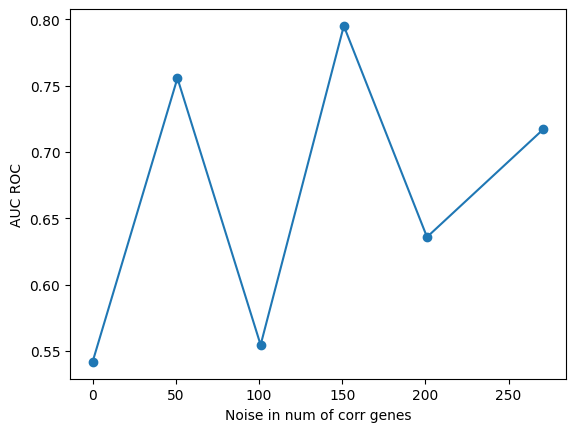

In [411]:
plt.plot(nosy_genes, auc_roc_list, "-o")
plt.ylabel("AUC ROC")
plt.xlabel("Noise in num of corr genes")
plt.show()

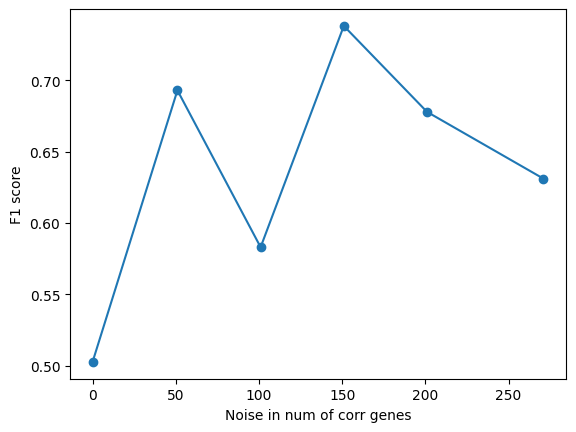

In [412]:
plt.plot(nosy_genes, f1_list, "-o")
plt.ylabel("F1 score")
plt.xlabel("Noise in num of corr genes")
plt.show()

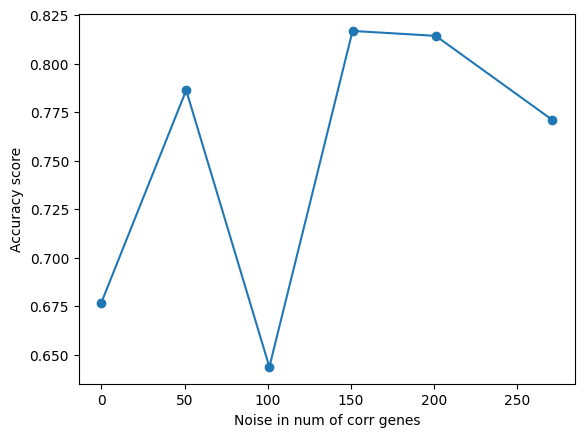

In [413]:
plt.plot(nosy_genes, accuracy_list, "-o")
plt.ylabel("Accuracy score")
plt.xlabel("Noise in num of corr genes")
plt.show()

In [416]:
float(classification_metrics_df["f1-score"][0])

0.09

In [417]:
def plot_f1_score(i):
    f1_score = [
        float(classification_metrics_df["f1-score"][i]),
        float(classification_metrics_df_51["f1-score"][i]),
        float(classification_metrics_df_101["f1-score"][i]),
        float(classification_metrics_df_151["f1-score"][i]),
        float(classification_metrics_df_201["f1-score"][i]),
        float(classification_metrics_df_271["f1-score"][i]),
    ]

    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("f1 score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()

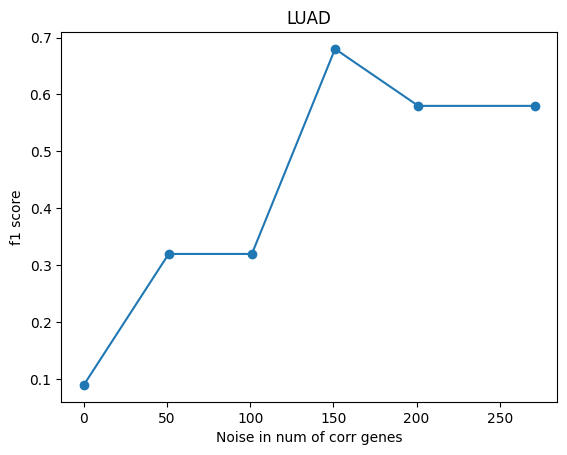

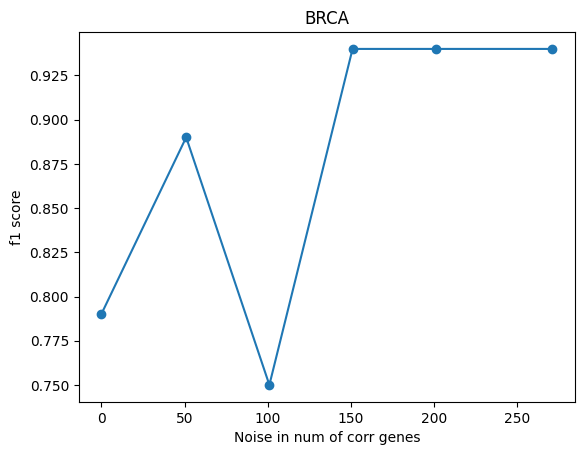

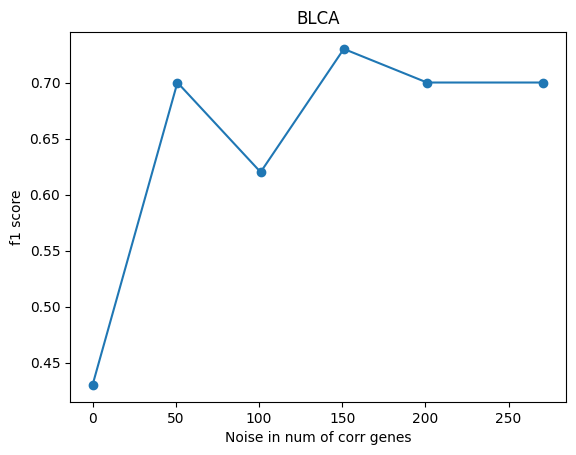

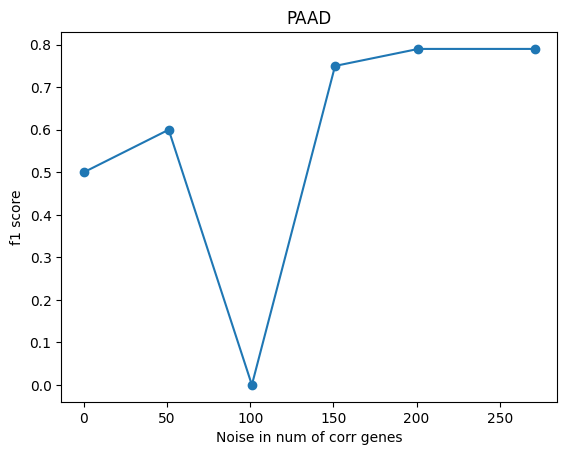

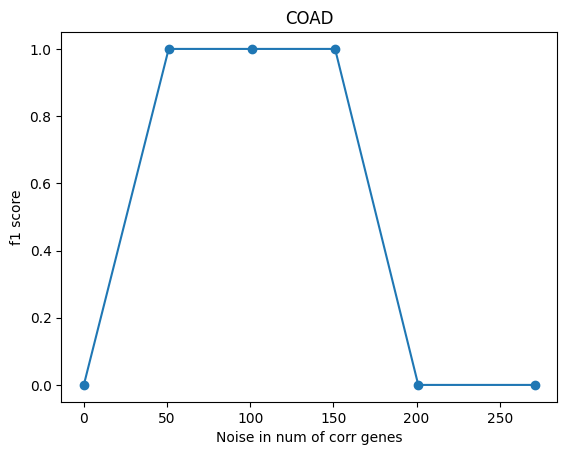

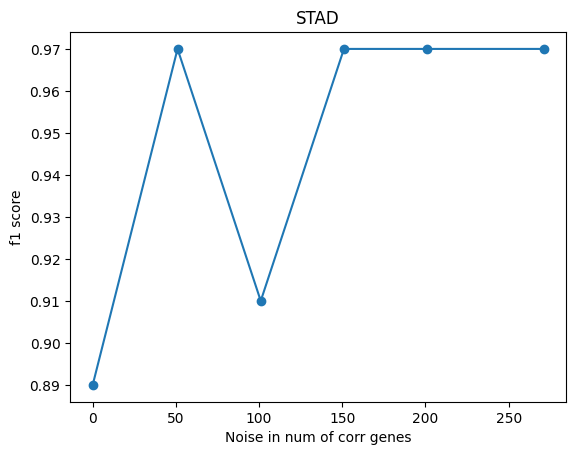

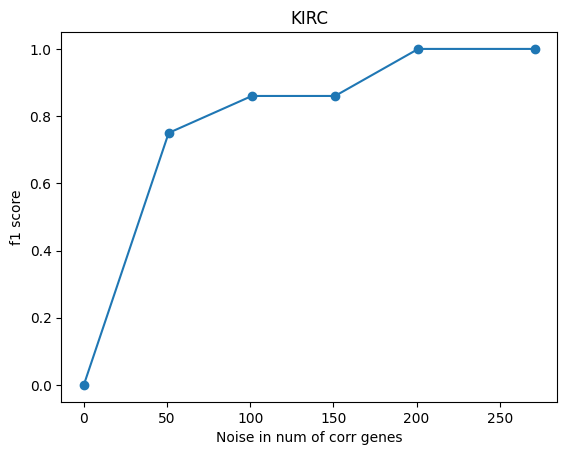

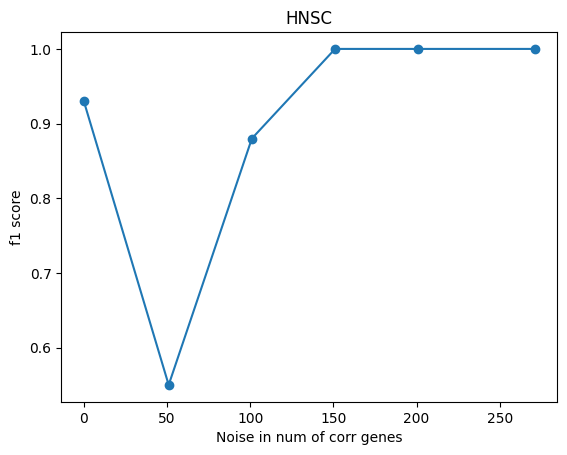

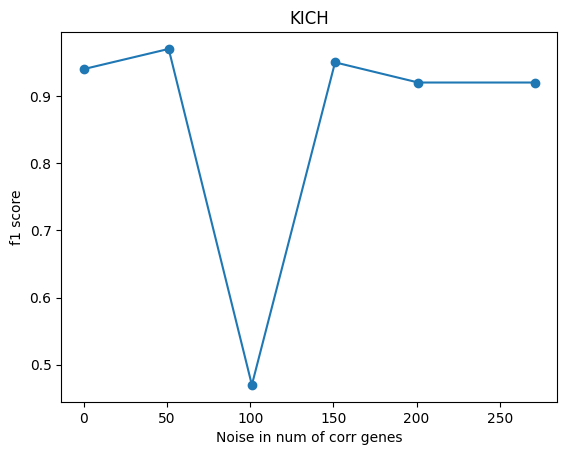

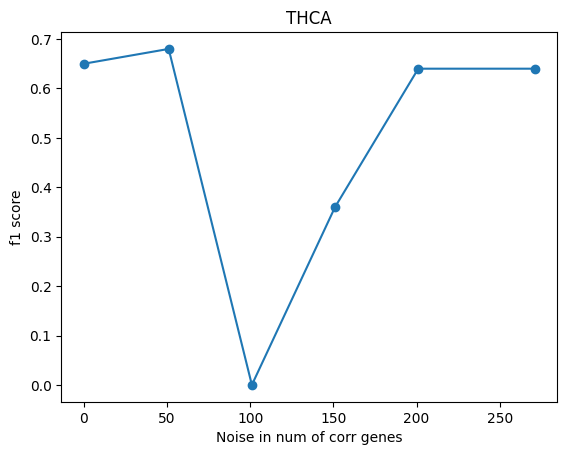

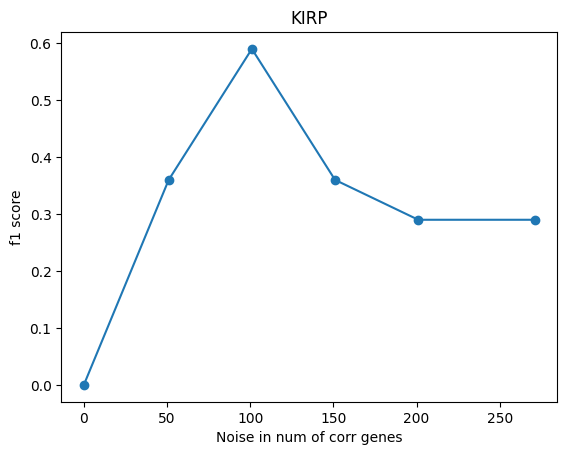

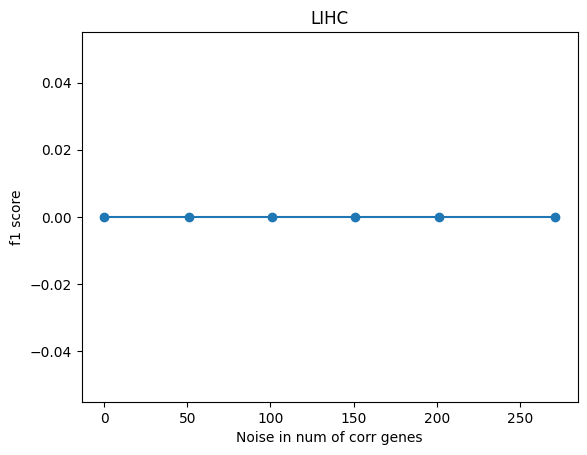

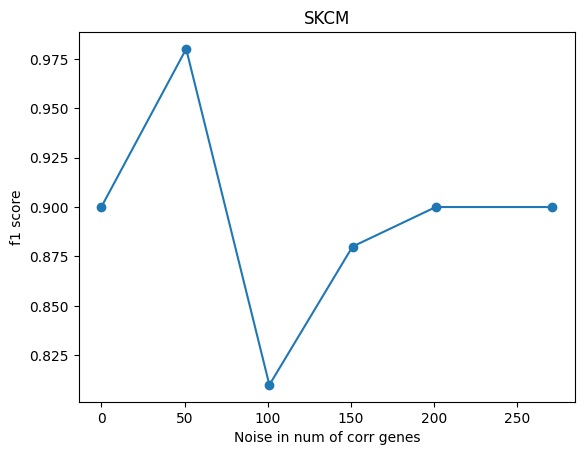

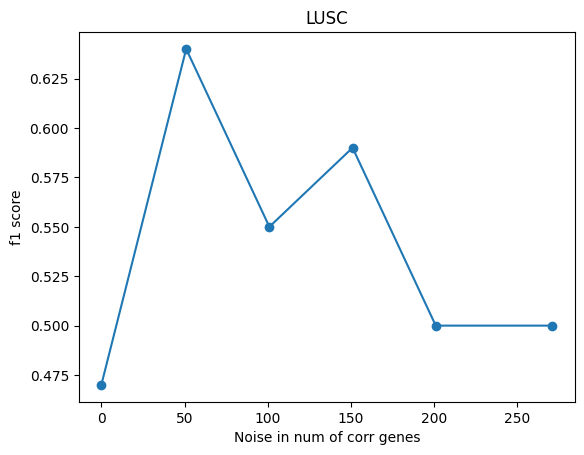

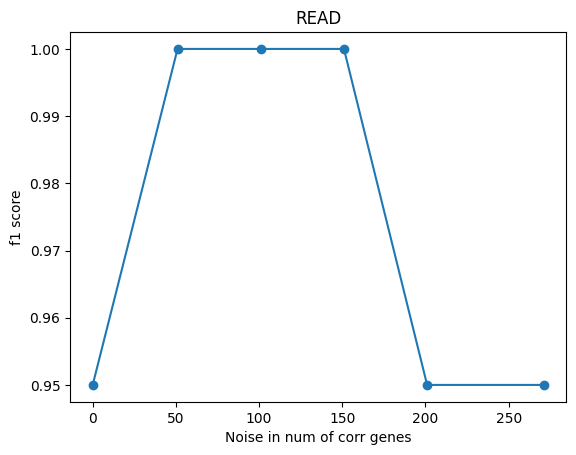

In [418]:
for i in range(15):
    plot_f1_score(i)

In [419]:
def plot_precision_score(i):
    f1_score = [
        float(classification_metrics_df["precision"][i]),
        float(classification_metrics_df_51["precision"][i]),
        float(classification_metrics_df_101["precision"][i]),
        float(classification_metrics_df_151["precision"][i]),
        float(classification_metrics_df_201["precision"][i]),
        float(classification_metrics_df_271["precision"][i]),
    ]

    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("precision score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()

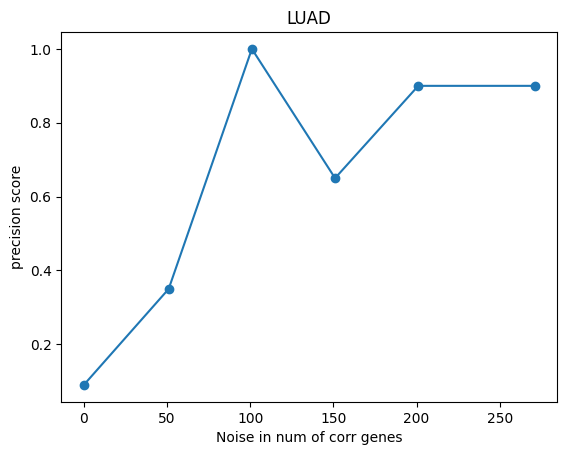

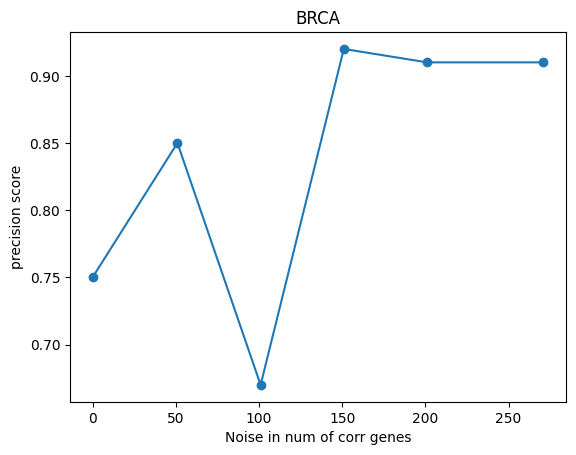

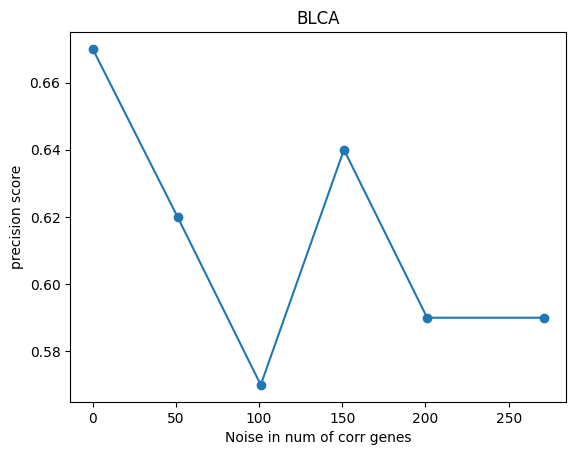

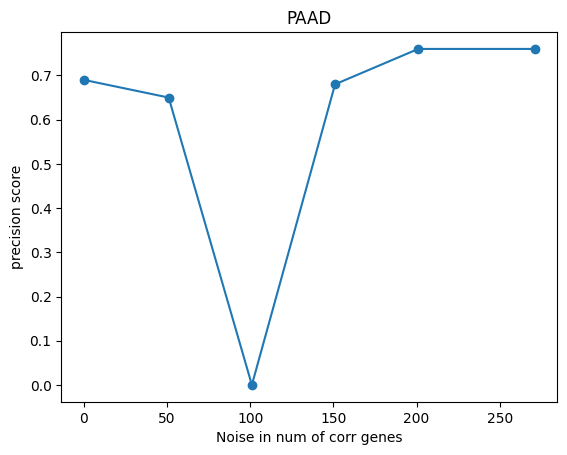

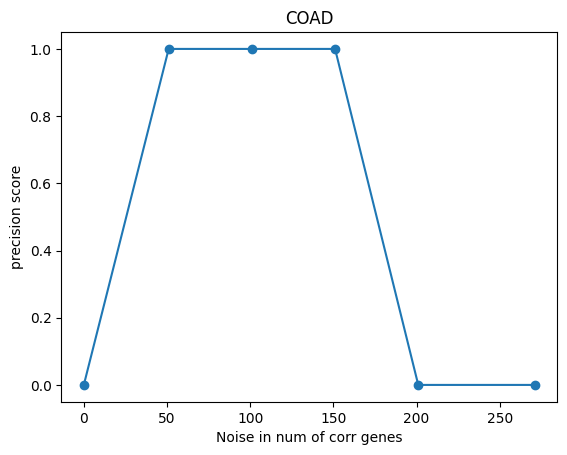

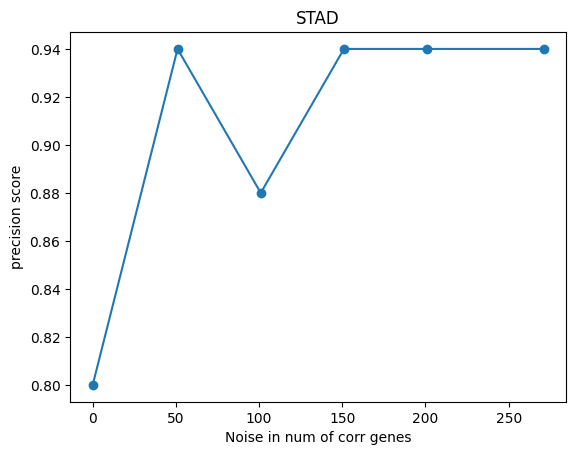

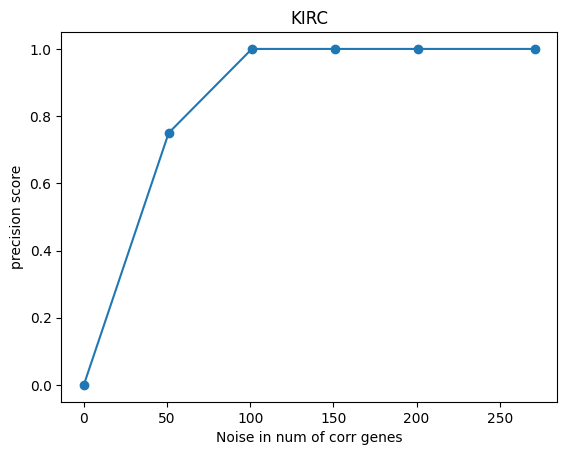

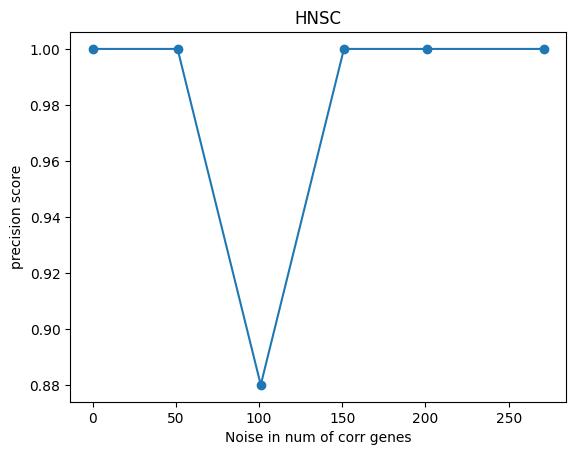

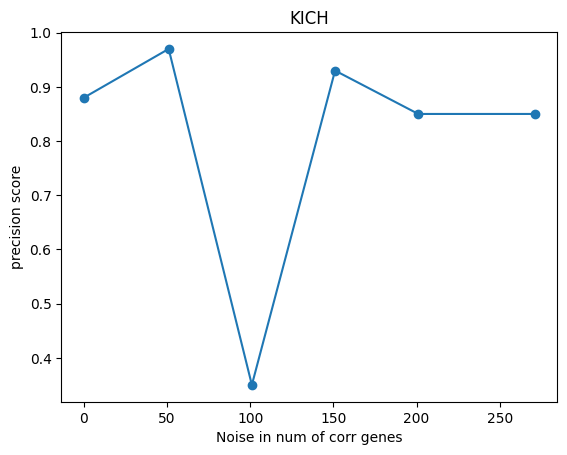

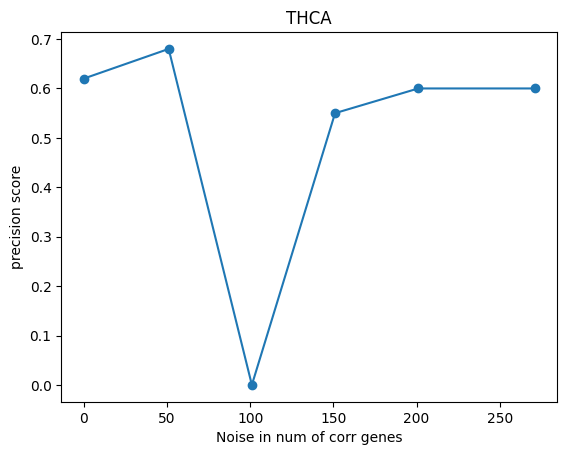

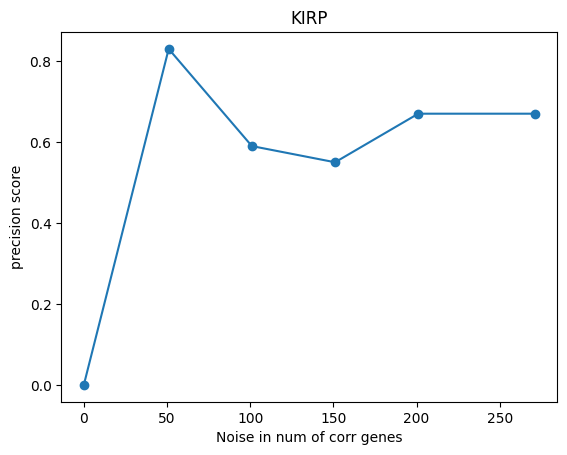

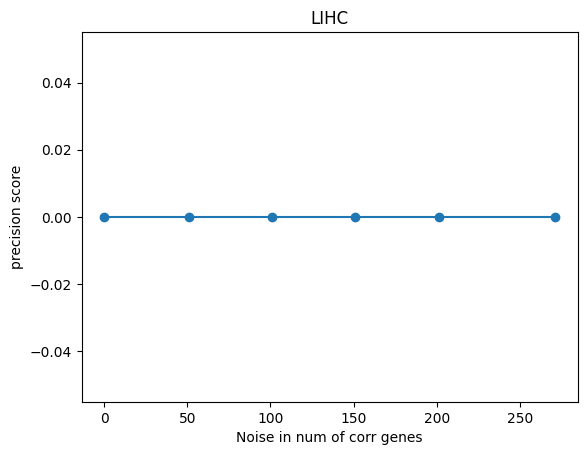

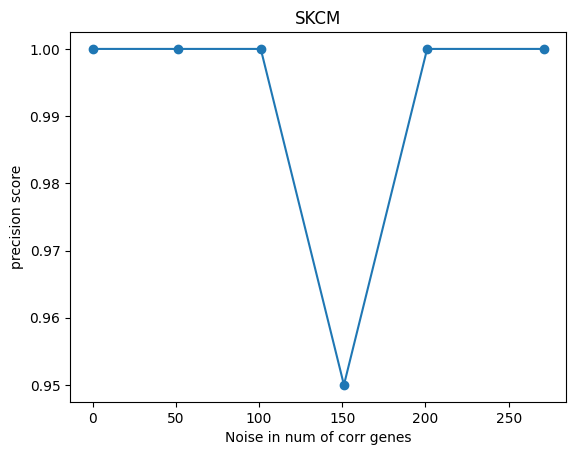

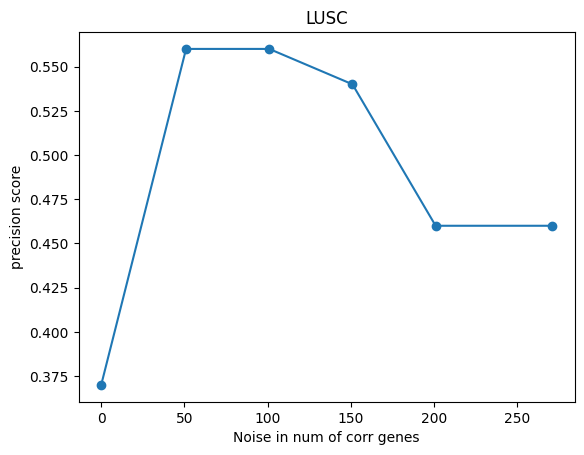

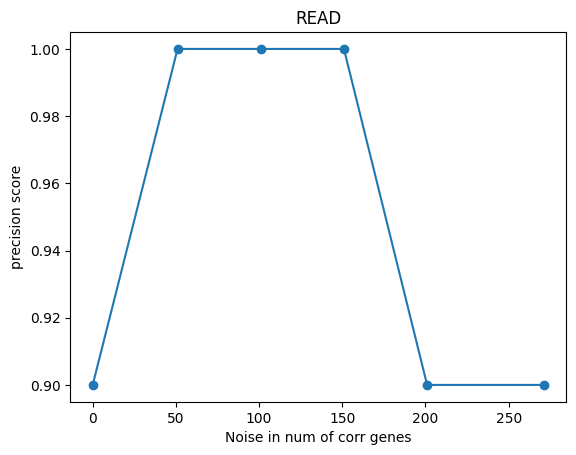

In [420]:
for i in range(15):
    plot_precision_score(i)

In [421]:
def plot_recall_score(i):
    f1_score = [
        float(classification_metrics_df["recall"][i]),
        float(classification_metrics_df_51["recall"][i]),
        float(classification_metrics_df_101["recall"][i]),
        float(classification_metrics_df_151["recall"][i]),
        float(classification_metrics_df_201["recall"][i]),
        float(classification_metrics_df_271["recall"][i]),
    ]

    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("recall score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()

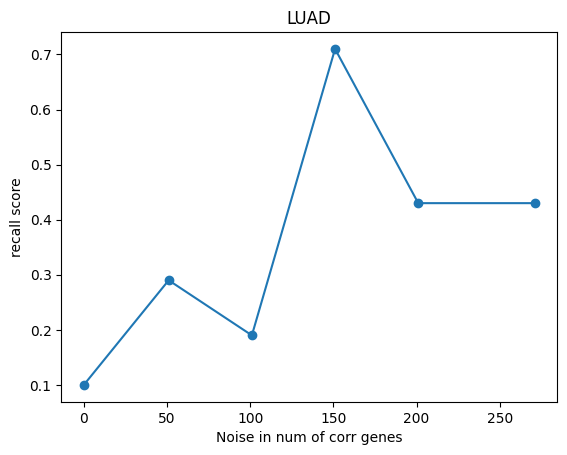

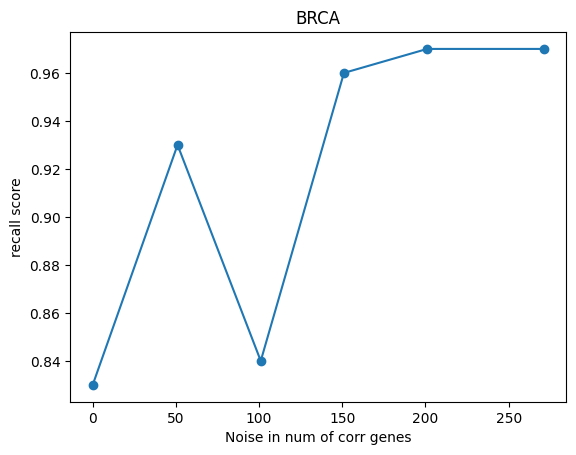

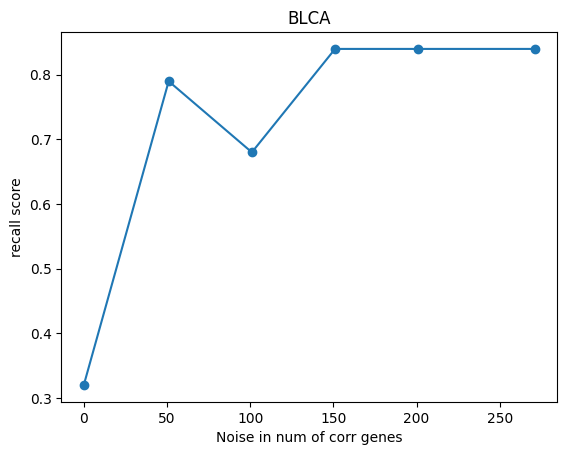

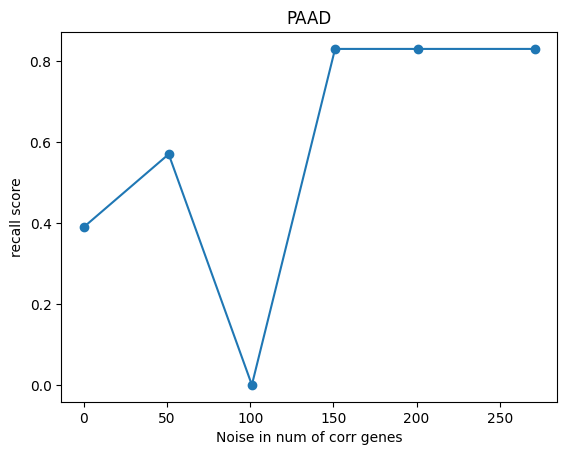

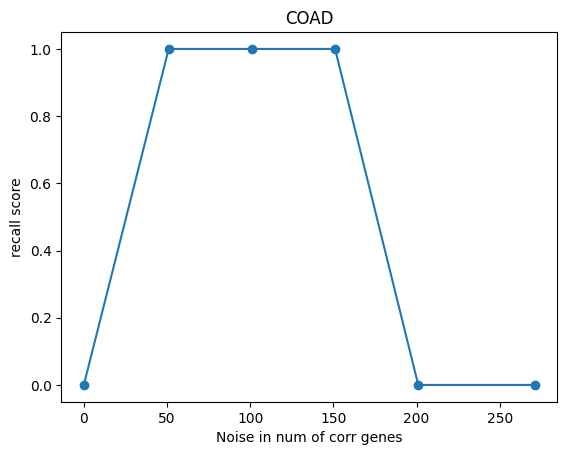

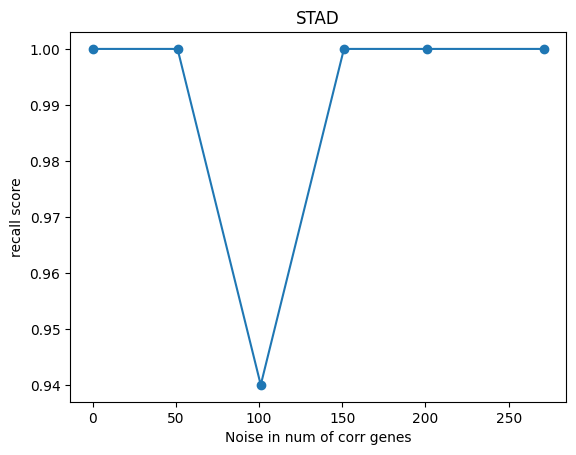

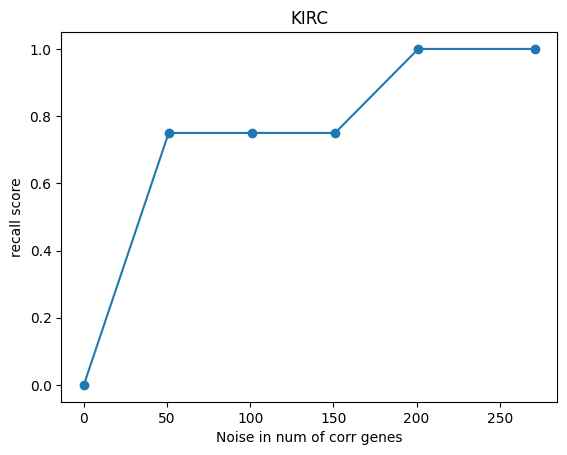

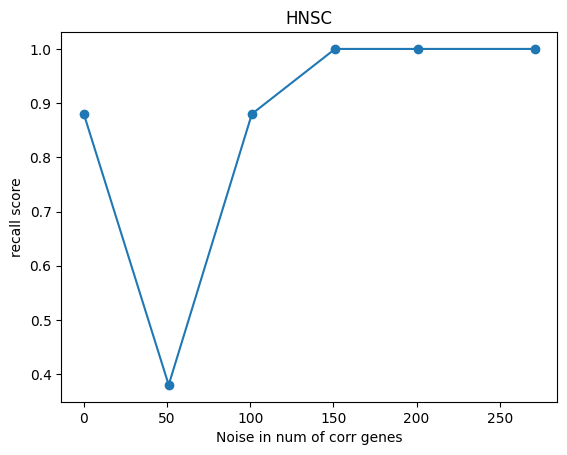

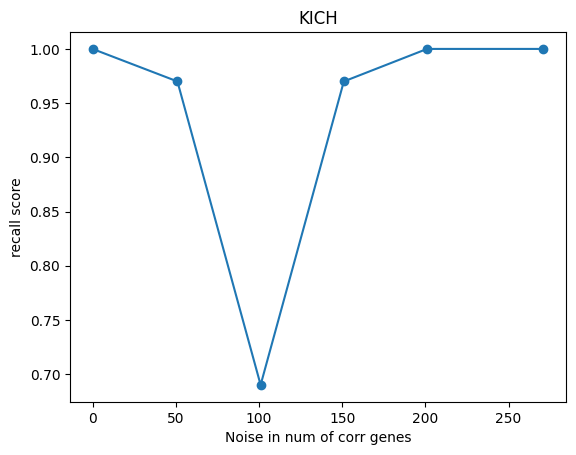

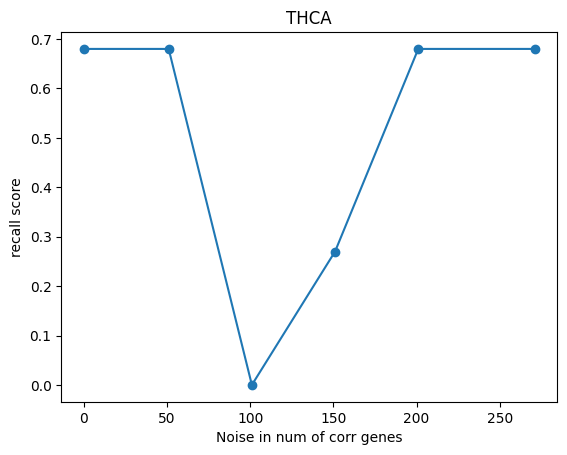

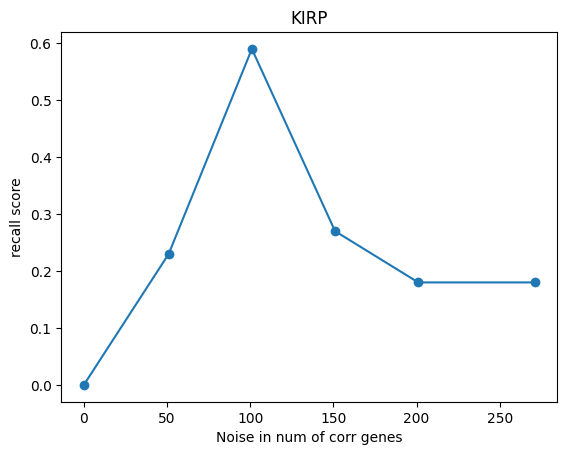

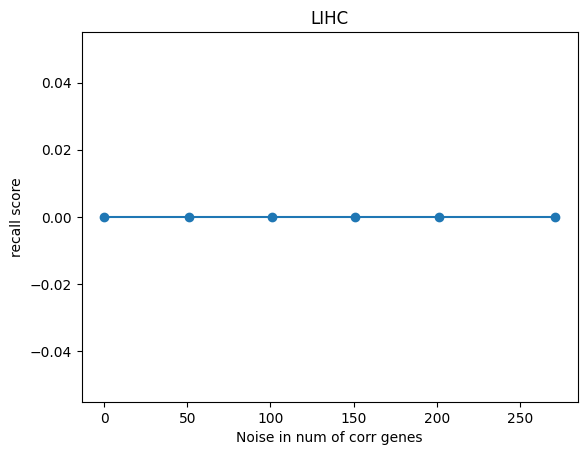

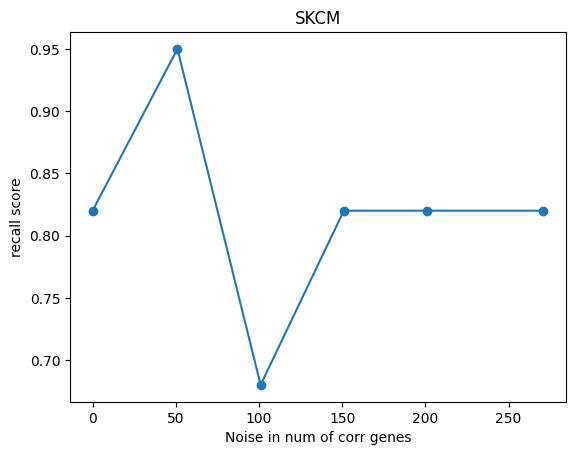

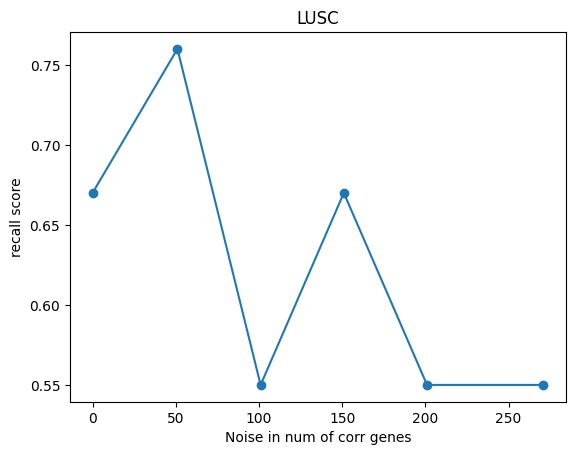

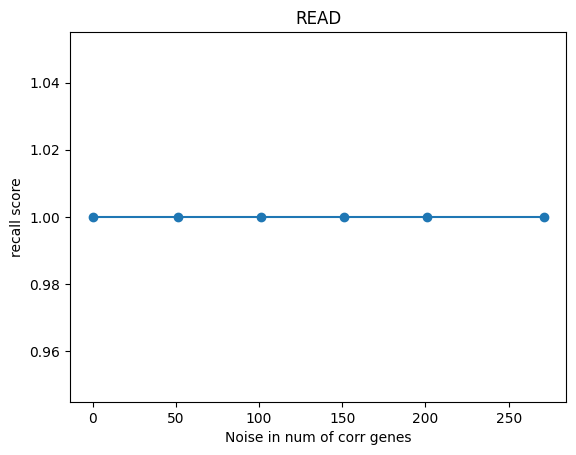

In [422]:
for i in range(15):
    plot_recall_score(i)

### Check other classification algarithms to make sure results are correct

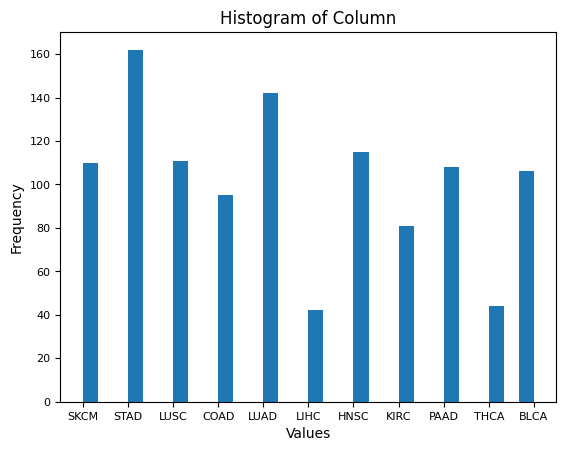

In [462]:
# Check cancertype distribution in clinical dataset
cancer_distribution = merged_l_df.copy()
acronyms = list(arcronym_dict.values())
elements_to_remove = ["BRCA", "KICH", "READ", "KIRP"]
new_list = [x for x in acronyms if x not in elements_to_remove]
filtered_df = cancer_distribution[cancer_distribution["acronym"].isin(new_list)]
plt.hist(filtered_df["acronym"], bins=30)  # Adjust the number of bins as desired

# Set labels and title
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Column")

# Set tick label size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Show the plot
plt.show()

In [467]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df_tcga_tybalt = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

['LUAD',
 'BLCA',
 'PAAD',
 'COAD',
 'STAD',
 'KIRC',
 'HNSC',
 'THCA',
 'LIHC',
 'SKCM',
 'LUSC']

In [489]:
# define a function which gives results for multiclass classification
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)


def cancer_classification(df):
    latent_mu, latent_sigma = VAE_latent_out(df)
    # Extract the features from the DataFrame
    features = latent_mu.iloc[:, 0:-1].values

    # Perform UMAP dimensionality reduction
    umap_result = umap.UMAP().fit_transform(features)

    # Create a new DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

    # Concatenate the UMAP DataFrame with the original DataFrame
    result_df = pd.concat([latent_mu, umap_df], axis=1)
    embedded_dataframe = result_df.copy()
    embedded_dataframe["id"] = df_tcga_tybalt["Unnamed: 0"]

    merged_latent_clinical_df = pd.merge(
        clincal_df, embedded_dataframe, on="id", how="inner"
    )

    # Split the DataFrame into features (X) and labels (y)
    merged_l_df = merged_latent_clinical_df.copy()
    merged_l_df = merged_l_df.dropna()

    column_name = "acronym"
    n = 2

    merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

    merged_l_df = merged_l_df[merged_l_df["acronym"].isin(new_list)]

    merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

    X = merged_l_df[["UMAP1", "UMAP2"]]
    y = merged_l_df["acronym"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize and train the classifier
    QDA = QuadraticDiscriminantAnalysis()
    classifier = QDA
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Compute roc_auc_score
    auc_roc = roc_auc_score(
        pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro"
    )

    # Compute F1-score
    f1 = f1_score(y_test, y_pred, average="macro")

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute classification report
    classification_metrics = classification_report(y_test, y_pred)

    # Print the AUC-ROC, F1-score, accuracy, and classification report
    # print("AUC-ROC:", auc_roc)
    # print("F1-score:", f1)
    # print("Accuracy:", accuracy)
    # print("Classification Report:\n", classification_metrics)

    return f1, auc_roc, accuracy, classification_metrics

In [484]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

In [485]:
cancer_classification(noisy_inputs[61])[0]

0.828213024554488

In [486]:
f1_cancer_classification = [
    cancer_classification(noisy_inputs[i])[0] for i in noisy_inputs.keys()
]

Text(0, 0.5, 'f1 score')

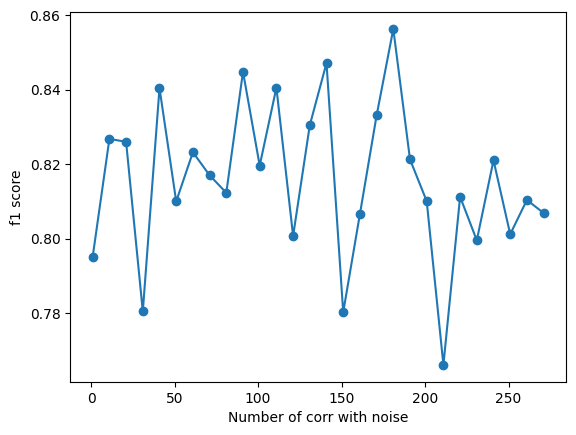

In [496]:
plt.plot(list(noisy_inputs.keys()), f1_cancer_classification, "-o")
plt.xlabel("Number of corr with noise")
plt.ylabel("f1 score")

In [490]:
auc_roc_cancer_classification = [
    cancer_classification(noisy_inputs[i])[1] for i in noisy_inputs.keys()
]

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'AUC ROC')

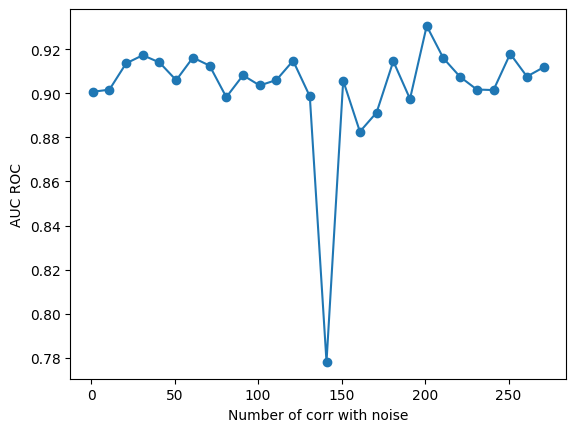

In [495]:
plt.plot(list(noisy_inputs.keys()), auc_roc_cancer_classification, "-o")
plt.xlabel("Number of corr with noise")
plt.ylabel("AUC ROC")

In [492]:
accuracy_cancer_classification = [
    cancer_classification(noisy_inputs[i])[2] for i in noisy_inputs.keys()
]

Text(0, 0.5, 'Accuracy')

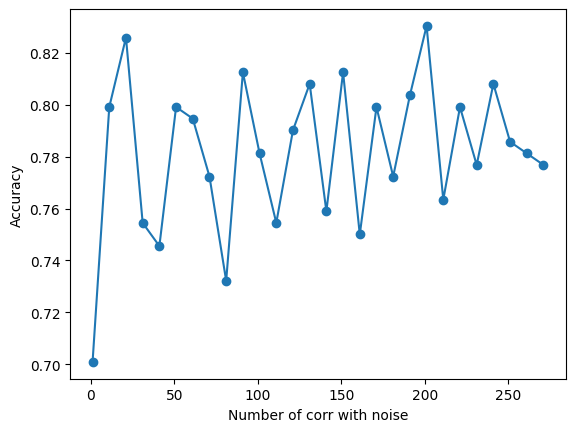

In [494]:
plt.plot(list(noisy_inputs.keys()), accuracy_cancer_classification, "-o")
plt.xlabel("Number of corr with noise")
plt.ylabel("Accuracy")

In [ ]:
def plot_f1_score(i):
    f1_score = [
        float(classification_metrics_df["f1-score"][i]),
        float(classification_metrics_df_51["f1-score"][i]),
        float(classification_metrics_df_101["f1-score"][i]),
        float(classification_metrics_df_151["f1-score"][i]),
        float(classification_metrics_df_201["f1-score"][i]),
        float(classification_metrics_df_271["f1-score"][i]),
    ]

    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("f1 score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()

In [505]:
# Convert classification report to DataFrame
def classification_report_to_DataFrame(classification_metrics):
    report_data = []
    lines = classification_metrics.strip().split("\n")
    for line in lines[2:-3]:
        row = line.split()
        report_data.append(row)

    classification_metrics_df = pd.DataFrame(
        report_data, columns=["class", "precision", "recall", "f1-score", "support"]
    )
    
    for column in classification_metrics_df.columns:
        # Apply float() function to the column
        classification_metrics_df[column] = classification_metrics_df[column].apply(lambda x: float(x) if isinstance(x, str) else x)

    return classification_metrics_df

In [507]:
classification_report_to_DataFrame(cancer_classification(noisy_inputs[1])[3])

class  precision  recall  f1-score  support
0     0.0       0.85    0.52      0.65     21.0
1     1.0       0.62    0.95      0.75     19.0
2     2.0       0.60    0.91      0.72     23.0
3     3.0       0.94    1.00      0.97     16.0
4     4.0       1.00    0.88      0.93      8.0
5     5.0       1.00    0.97      0.98     29.0
6     6.0       0.55    0.50      0.52     22.0
7     7.0       0.50    0.86      0.63     22.0
8     8.0       0.92    1.00      0.96     22.0
9     9.0       1.00    0.12      0.22     33.0
10   10.0       1.00    1.00      1.00      9.0
11    NaN        NaN     NaN       NaN      NaN

In [512]:
# generate plots
def generate_plots(class_i):
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for i in noisy_inputs.keys():
        classification_report = classification_report_to_DataFrame(cancer_classification(noisy_inputs[i])[3])
        precision_scores.append(classification_report["precision"][class_i])
        recall_scores.append(classification_report["recall"][class_i])
        f1_scores.append(classification_report["f1-score"][class_i])
    
    plt.plot(list(noisy_inputs.keys()), precision_scores, "-o")
    plt.title(arcronym_dict[class_i])
    plt.xlabel("Number of corr with noise")
    plt.ylabel("Precision scores")
    plt.show()
    
    plt.plot(list(noisy_inputs.keys()), recall_scores, "-o")
    plt.title(arcronym_dict[class_i])
    plt.xlabel("Number of corr with noise")
    plt.ylabel("Recall scores")
    plt.show()
    
    plt.plot(list(noisy_inputs.keys()), f1_scores, "-o")
    plt.title(arcronym_dict[class_i])
    plt.xlabel("Number of corr with noise")
    plt.ylabel("f1scores")
    plt.show()

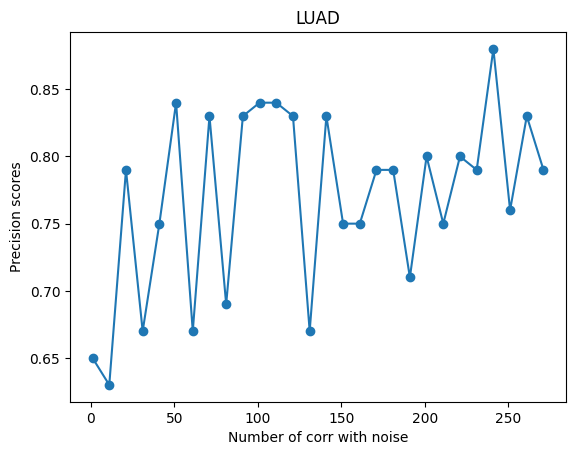

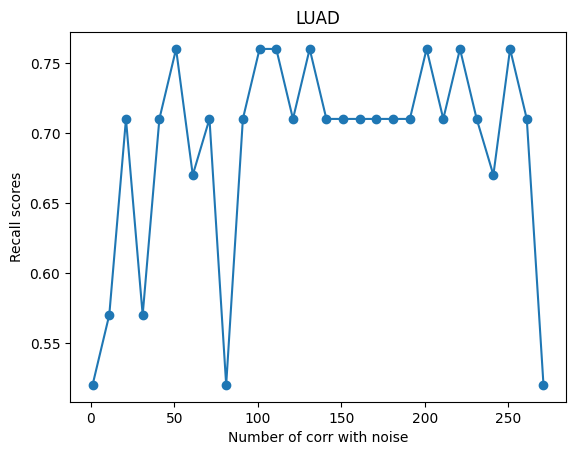

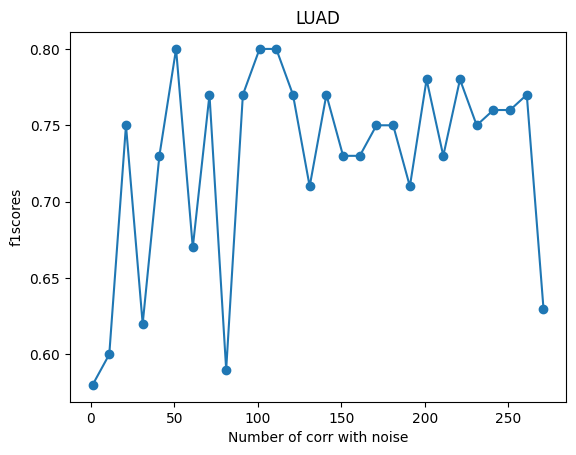

In [513]:
generate_plots(0)

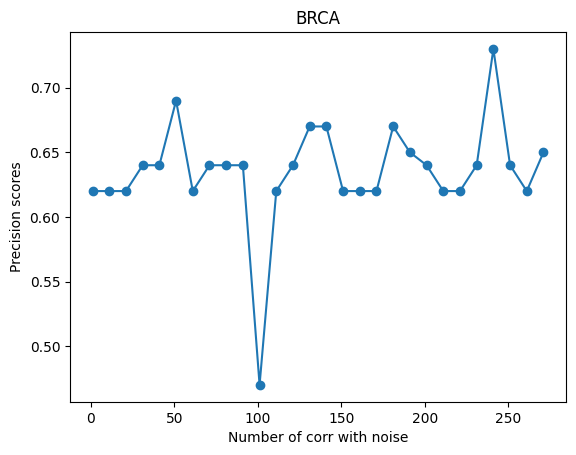

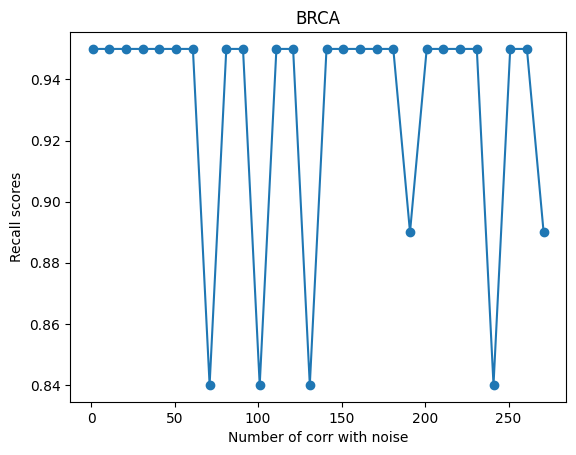

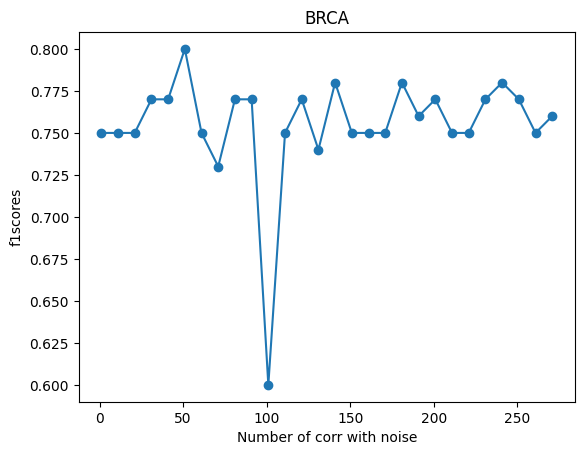

In [514]:
generate_plots(1)

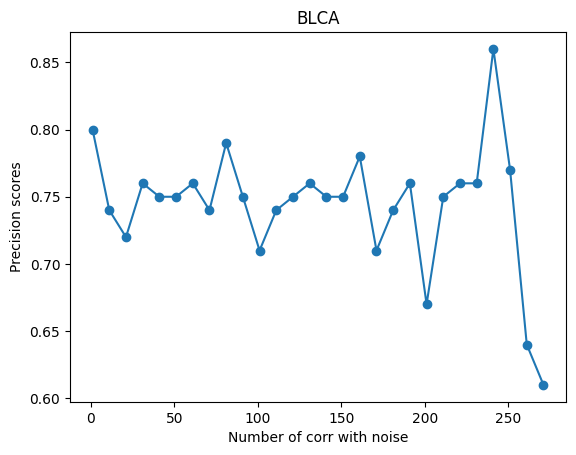

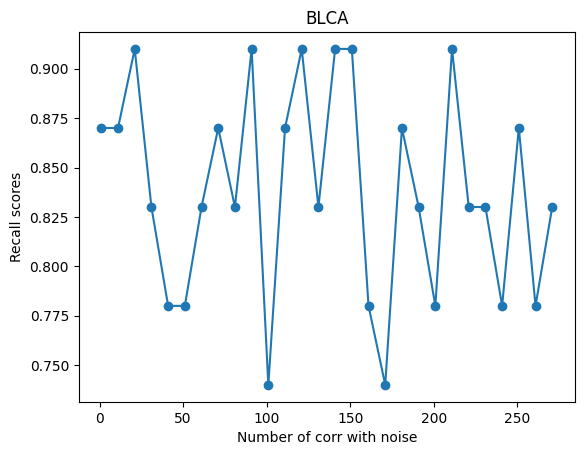

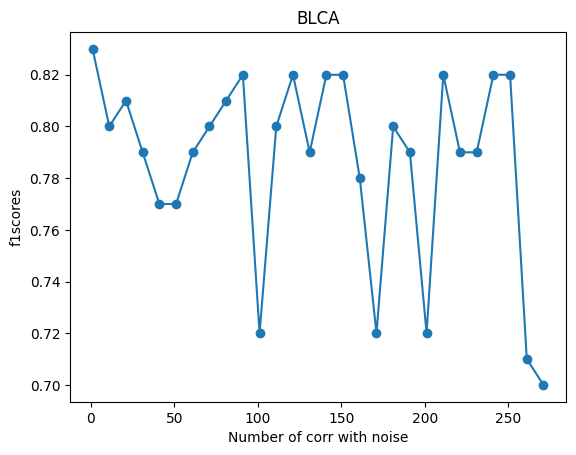

In [515]:
generate_plots(2)

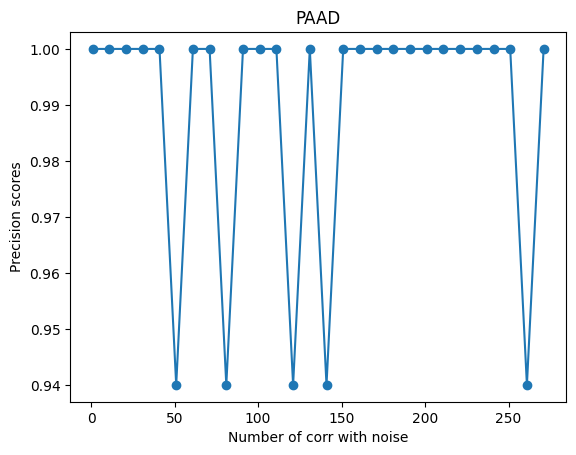

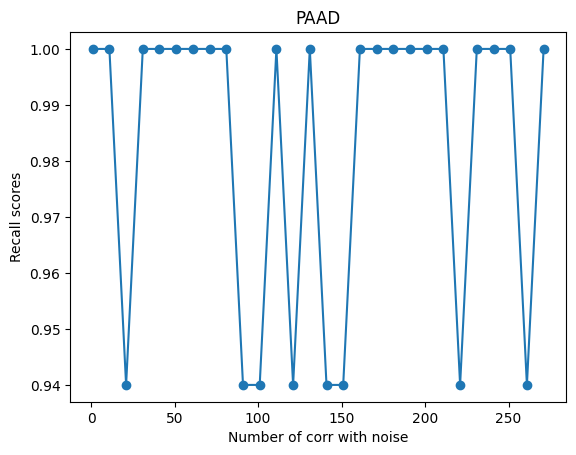

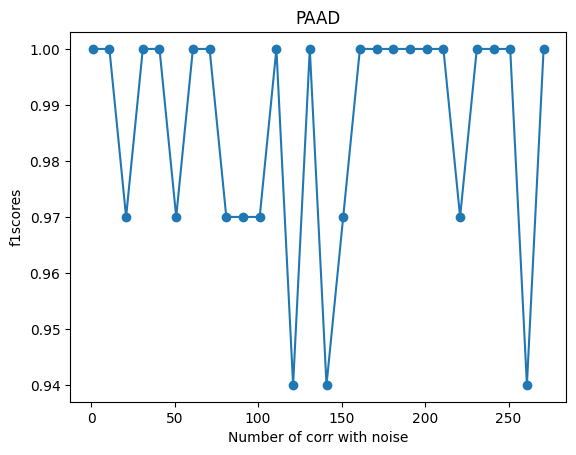

In [516]:
generate_plots(3)

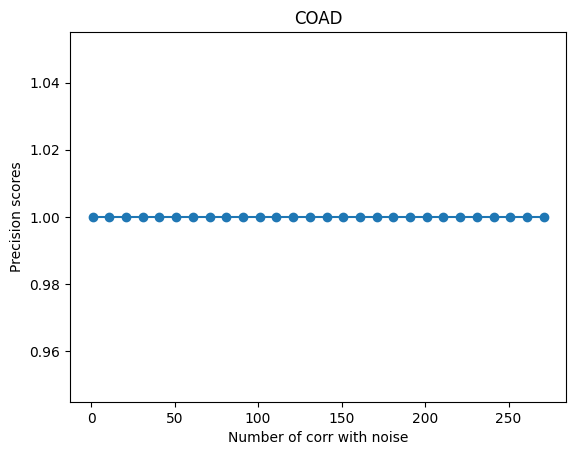

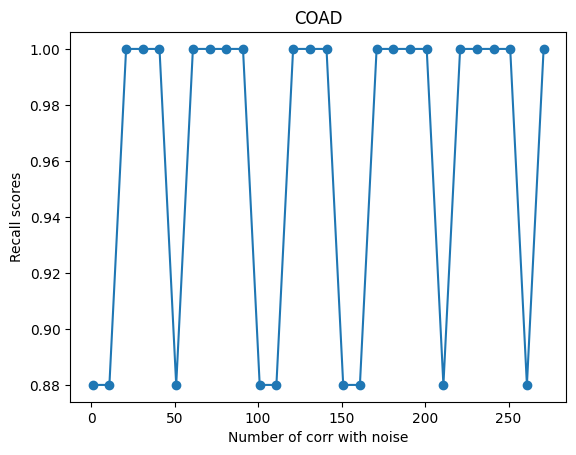

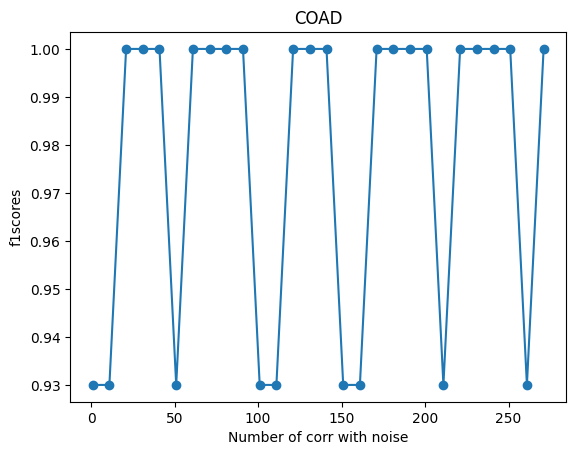

In [517]:
generate_plots(4)

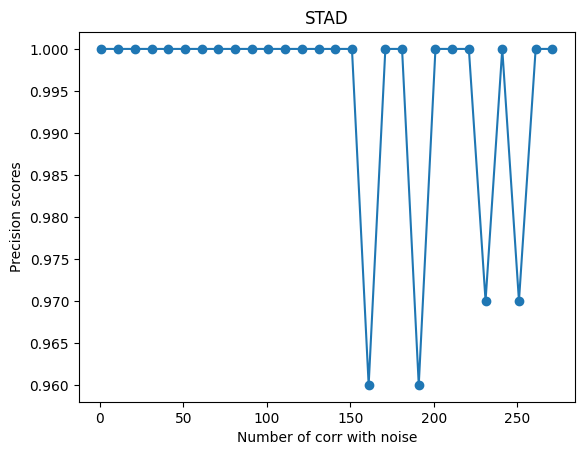

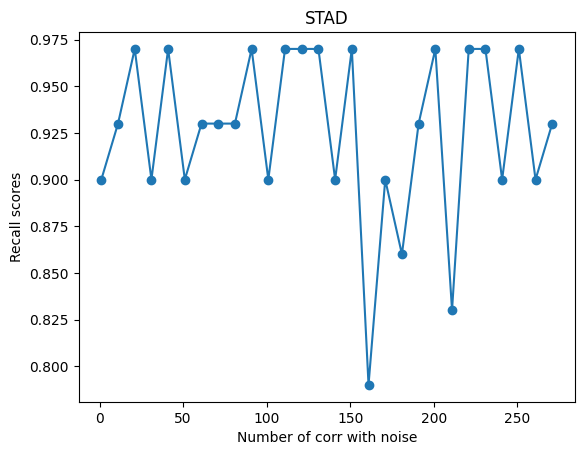

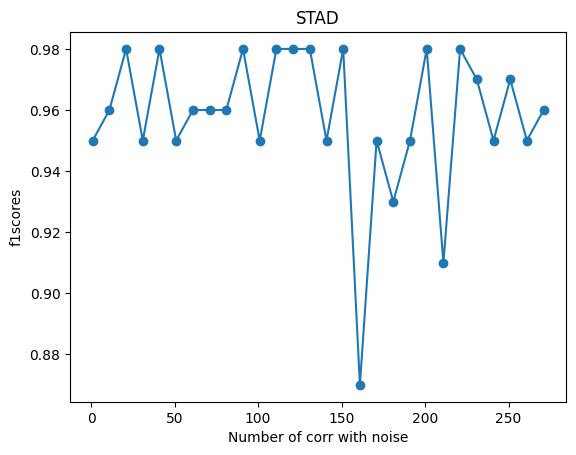

In [518]:
generate_plots(5)

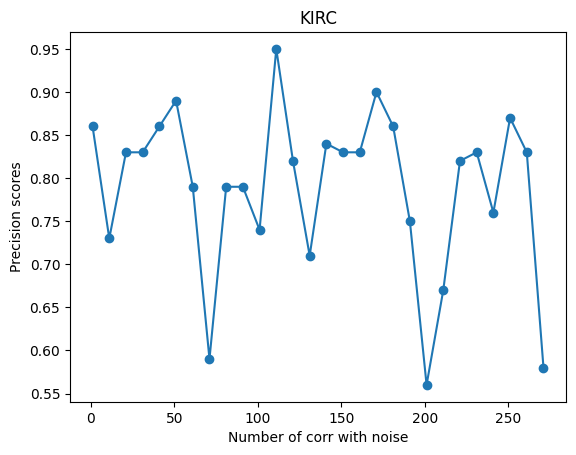

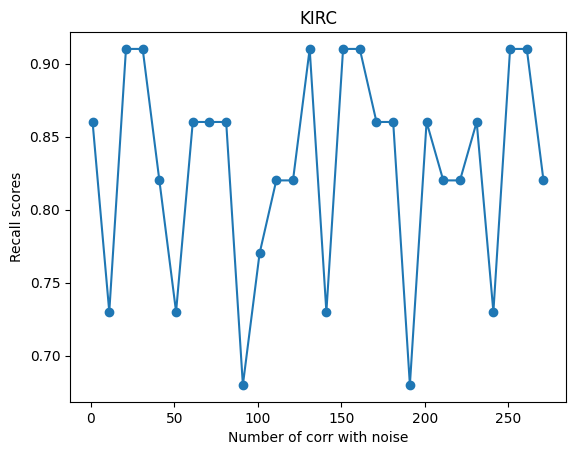

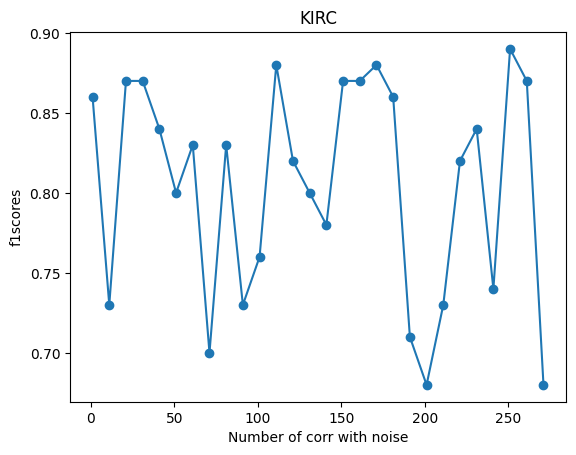

In [519]:
generate_plots(6)

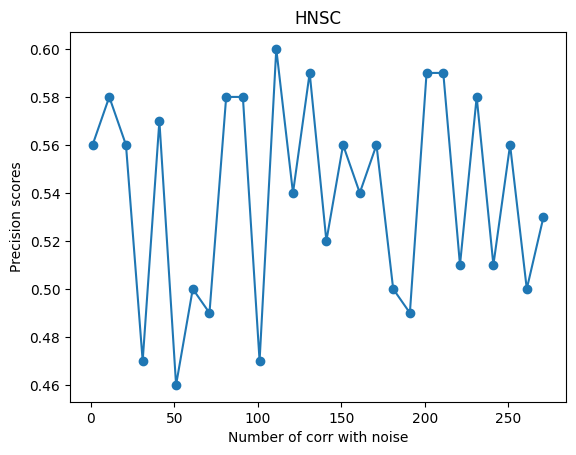

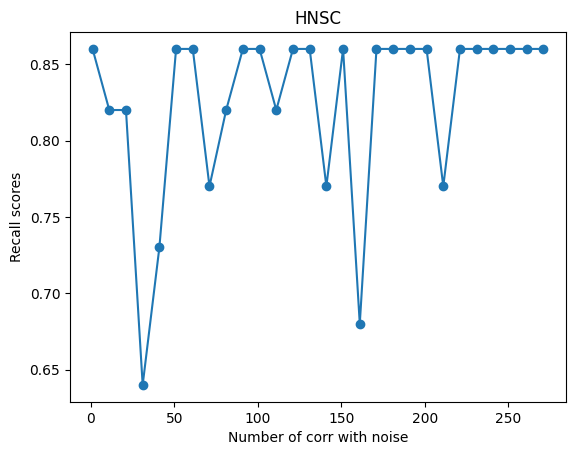

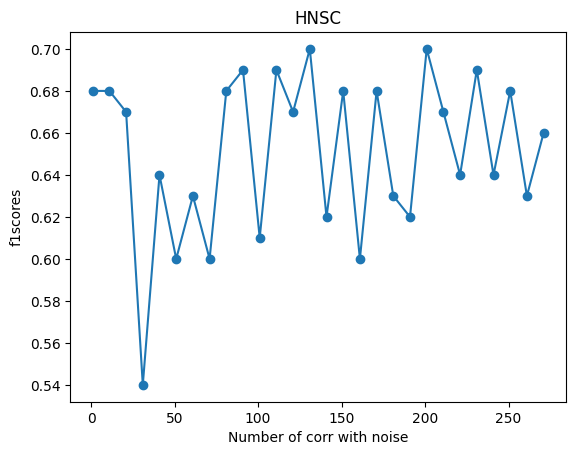

In [520]:
generate_plots(7)

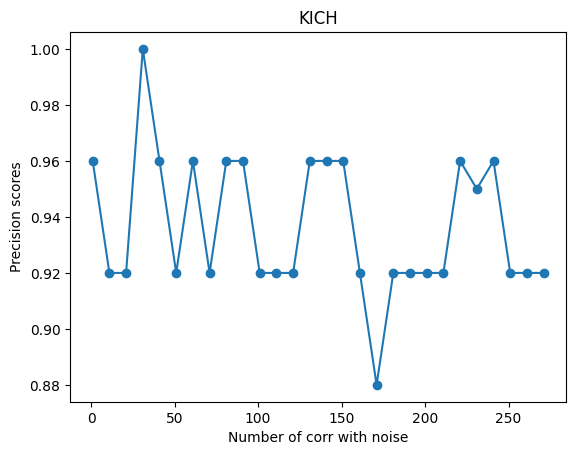

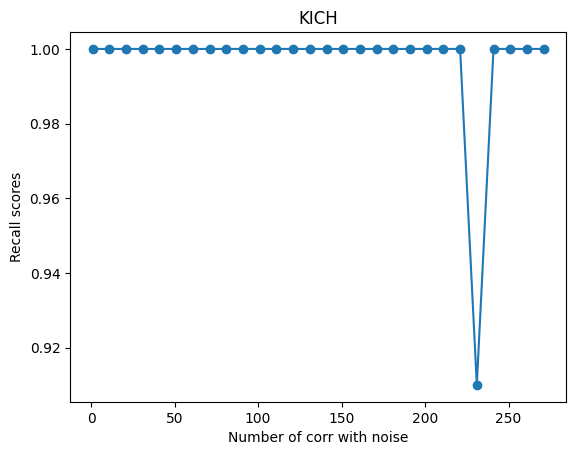

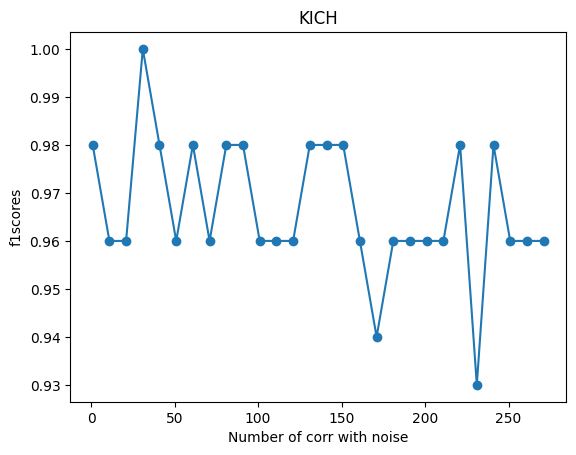

In [521]:
generate_plots(8)